<a href="https://www.kaggle.com/code/erikanesse/mnist-gan-ac775a?scriptVersionId=139205774" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# GAN: Generative adversarial network

Networks:
* Generator: Tries to generate something like a digit
* Discriminator: Tries to tell apart real from generated digits

Steps:
* The generator generates based on a random input, producing an image
* The discriminator assigns a value from 0 to 1 of how likely it thinks this is a real image
* The loss is determined by how far off the discriminator is


# Step 1: Data

In [2]:
import csv
import numpy as np

In [3]:


train_x = []
train_y = []

with open('/kaggle/input/digit-recognizer/train.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    firstline = next(csvreader)
    for line in csvreader:
        train_y.append(int(line[0]))
        line = line[1:]
        line = [int(numeral) for numeral in line]
        train_x.append(line)
        
        
    
train_x = np.array(train_x, dtype=float)
train_x /= 255.0
train_x *= 2
train_x -= 1.0
train_y = np.array(train_y)


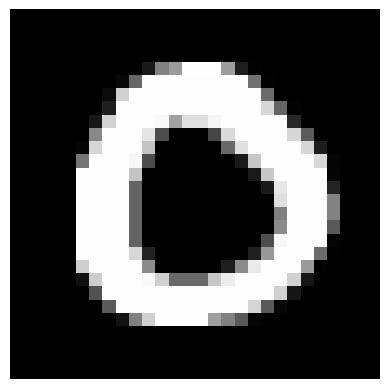

In [4]:
from matplotlib import pyplot as plt
plt.imshow(train_x[4].reshape(28, 28),cmap='gray', vmin=-1, vmax=1)
plt.axis("off")
plt.show()

# Create GAN
## Generator

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
class Generator(tf.keras.Model):

    def __init__(self):
        super().__init__()
        N = 10
        seq1 = keras.Sequential([layers.Dense(100, activation="relu") for i in range(N)])
        seq2 = keras.Sequential([layers.Dense(200, activation="relu") for i in range(N)])
        seq3 = keras.Sequential([layers.Dense(300, activation="relu") for i in range(N)])
        seq4 = keras.Sequential([layers.Dense(500, activation="relu") for i in range(N)])
        self.seq = keras.Sequential([seq1, seq2, seq3, layers.Dense(784)])

        
    def call(self, x):
  

        # upsample
        return self.seq(x)
    
    
    

In [7]:
gen_model = Generator()

In [8]:
x =  2*np.random.random_sample((3, 10)) - 1
gen_model(x)
gen_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (3, 784)                  1582984   
                                                                 
Total params: 1,582,984
Trainable params: 1,582,984
Non-trainable params: 0
_________________________________________________________________


In [9]:
x.shape

(3, 10)

In [10]:
output = gen_model(x)

In [11]:
output.shape

TensorShape([3, 784])

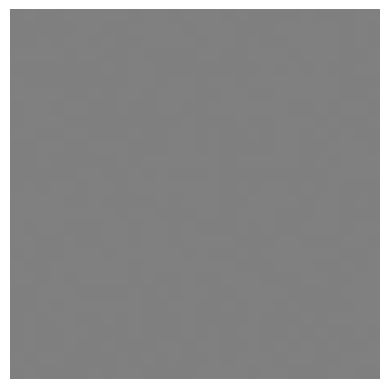

(1.0528979e-05, -1.0758121e-05)

In [12]:
from matplotlib import pyplot as plt
plt.imshow(output[1].numpy().reshape(28, 28),cmap='gray', vmin=-1, vmax=1)
plt.axis("off")
plt.show()
output[1].numpy().max(), output[1].numpy().min()


## Discriminator Classifier

In [13]:
FAKE_DATA_SIZE = 4200
REAL_DATA_SIZE = 4200
IMAGE_LENGTH = 784

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

N = 15  # Number of dense layers

discriminator = keras.Sequential()
for i in range(N):
    discriminator.add(layers.Dense(100, activation="relu"))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(2))
print(train_x.shape)
print(train_x[:3].shape)
discriminator(train_x[:3])
discriminator.summary()

discriminator.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

(42000, 784)
(3, 784)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (3, 100)                  78500     
                                                                 
 dense_42 (Dense)            (3, 100)                  10100     
                                                                 
 dense_43 (Dense)            (3, 100)                  10100     
                                                                 
 dense_44 (Dense)            (3, 100)                  10100     
                                                                 
 dense_45 (Dense)            (3, 100)                  10100     
                                                                 
 dense_46 (Dense)            (3, 100)                  10100     
                                                                 
 dense_47 (Dense)            (3,

# Helper class for training generator

In [15]:
class GenerateAndDiscriminate(tf.keras.Model):

    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator.trainable = False
        
    def call(self, x):
  
        x = self.generator(x)
        
    
        x = self.discriminator(x, training=False)
        # upsample
        return x
gandd = GenerateAndDiscriminate(gen_model, discriminator)
x =  np.random.random_sample((3, 10)) - 0.5
gandd(x)
gandd.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Generation training step

In [16]:
def train_generator():
    x =  np.random.random_sample((FAKE_DATA_SIZE, 10)) - 0.5
    train_y_gen = np.ones((FAKE_DATA_SIZE, 1))
    gandd.fit(x, train_y_gen, epochs=1,batch_size=5)

# Discriminator training step

In [17]:
def train_discriminator():

    
    # 0 is fake
    # 1 is real
    train_y_disc_real = np.ones((1, FAKE_DATA_SIZE))
    train_y_disc_fake = np.zeros((1, REAL_DATA_SIZE))
    
    x =  np.random.random_sample((FAKE_DATA_SIZE, 10)) - 0.5
    train_x_disc_fake = gen_model(x)
    
    train_y_disc = np.concatenate((train_y_disc_real, train_y_disc_fake), axis=1).flatten()
    
    np.random.shuffle(train_x)
    train_x_disc_real = train_x[:REAL_DATA_SIZE]
    train_x_disc = np.concatenate((train_x_disc_real, train_x_disc_fake))

    def unison_shuffled_copies(a, b):
        print(len(a))
        print(len(b))
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    train_x_disc_shuffled, train_y_disc_shuffled = unison_shuffled_copies(train_x_disc, train_y_disc)

    val_x_disc = train_x_disc_shuffled[:100]
    val_y_disc = train_y_disc_shuffled[:100]
    train_x_disc = train_x_disc_shuffled[100:]
    train_y_disc = train_y_disc_shuffled[100:]
    discriminator.fit(train_x_disc, train_y_disc, validation_data=(val_x_disc, val_y_disc), epochs=1,batch_size=5)

Step 0
Training discriminator
8400
8400
1660/1660 [==============================] - 11s 4ms/step - loss: 0.0036 - sparse_categorical_accuracy: 0.9996 - val_loss: 1.2398e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.58199   -8.8388   ]
 [ 6.5819864 -8.838797 ]
 [ 6.5819893 -8.8388   ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 13s 7ms/step - loss: 0.0768 - sparse_categorical_accuracy: 0.9940
Discriminator on random data after training generator:
tf.Tensor(
[[-13.499066  10.968333]
 [-13.645211  11.090128]
 [-13.543061  11.004997]], shape=(3, 2), dtype=float32)


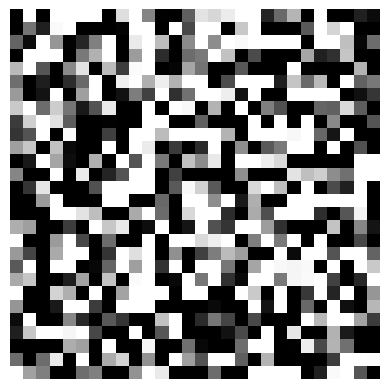

Step 1
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9980 - val_loss: 2.7418e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.192564  -10.282292 ]
 [  7.2248573 -10.330825 ]
 [  7.2424583 -10.357287 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9964
Discriminator on random data after training generator:
tf.Tensor(
[[-8.511284   7.3227816]
 [-8.507952   7.3198915]
 [-8.511204   7.322712 ]], shape=(3, 2), dtype=float32)


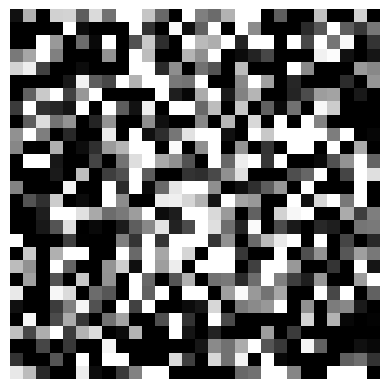

Step 2
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0038 - sparse_categorical_accuracy: 0.9993 - val_loss: 2.8610e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.2792635 -9.967772 ]
 [ 7.2812576 -9.9705305]
 [ 7.276167  -9.963491 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0247 - sparse_categorical_accuracy: 0.9976
Discriminator on random data after training generator:
tf.Tensor(
[[-7.9500303  7.54443  ]
 [-7.9499693  7.544373 ]
 [-7.950108   7.544503 ]], shape=(3, 2), dtype=float32)


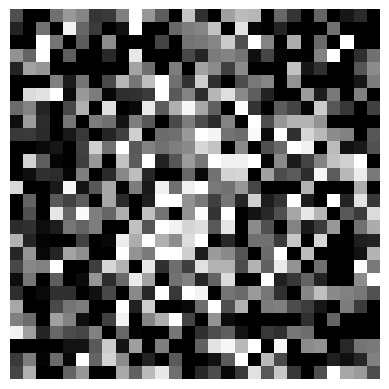

Step 3
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0040 - sparse_categorical_accuracy: 0.9998 - val_loss: 1.7881e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.787818  -10.70308  ]
 [  7.7878375 -10.703108 ]
 [  7.787775  -10.70302  ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0223 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.08596    7.0623903]
 [-8.085979   7.062408 ]
 [-8.086087   7.062501 ]], shape=(3, 2), dtype=float32)


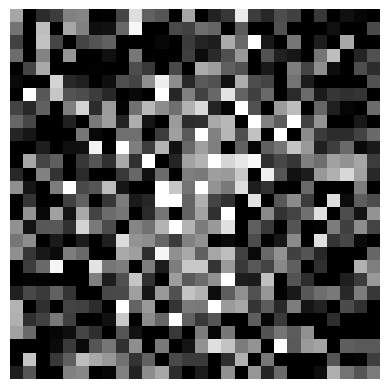

Step 4
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0059 - sparse_categorical_accuracy: 0.9987 - val_loss: 1.6689e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.4512305 -10.0629425]
 [  7.451262  -10.062984 ]
 [  7.451287  -10.06302  ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0211 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.490565   6.432719 ]
 [-8.490601   6.432748 ]
 [-8.490596   6.4327435]], shape=(3, 2), dtype=float32)


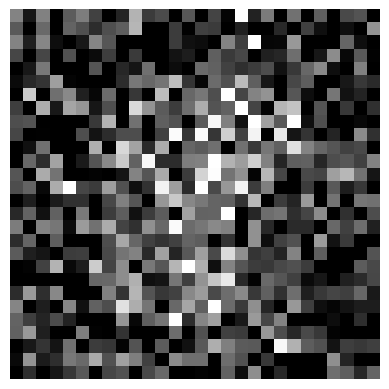

Step 5
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9960 - val_loss: 2.5034e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.2385817 -10.570981 ]
 [  7.23861   -10.57102  ]
 [  7.2385993 -10.571005 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.8155828  7.012188 ]
 [-7.8156314  7.012231 ]
 [-7.8156176  7.0122194]], shape=(3, 2), dtype=float32)


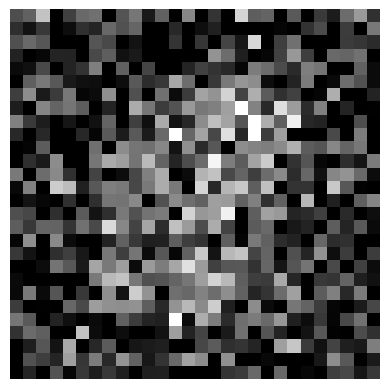

Step 6
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9978 - val_loss: 8.3446e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.052481  -9.663496 ]
 [ 7.052483  -9.663498 ]
 [ 7.0524735 -9.663485 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.7272964  6.827025 ]
 [-7.727281   6.82701  ]
 [-7.7272983  6.8270245]], shape=(3, 2), dtype=float32)


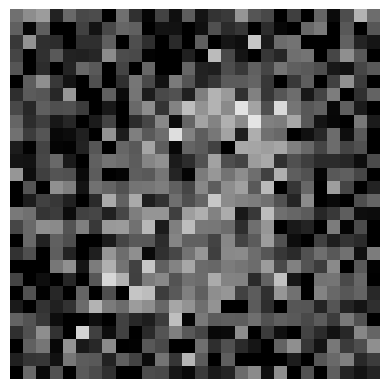

Step 7
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9967 - val_loss: 7.3910e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.559537  -9.009394 ]
 [ 7.5595446 -9.009404 ]
 [ 7.5595474 -9.009409 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0580 - sparse_categorical_accuracy: 0.9881
Discriminator on random data after training generator:
tf.Tensor(
[[-7.8468366  6.734758 ]
 [-7.846835   6.7347565]
 [-7.8468304  6.7347527]], shape=(3, 2), dtype=float32)


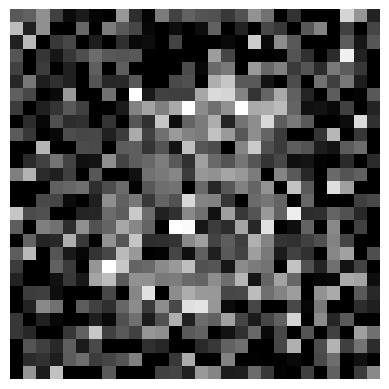

Step 8
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9989 - val_loss: 1.5497e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.1581   -9.757484]
 [ 7.158099 -9.757483]
 [ 7.158094 -9.757475]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.755974   6.6994634]
 [-7.756024   6.6995077]
 [-7.7560263  6.699509 ]], shape=(3, 2), dtype=float32)


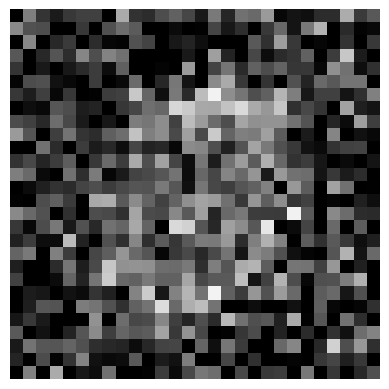

Step 9
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0092 - sparse_categorical_accuracy: 0.9987 - val_loss: 2.8610e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.9515634 -10.108696 ]
 [  7.9515686 -10.108702 ]
 [  7.9515753 -10.108707 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.8565354  6.5038433]
 [-7.856532   6.50384  ]
 [-7.8565354  6.503844 ]], shape=(3, 2), dtype=float32)


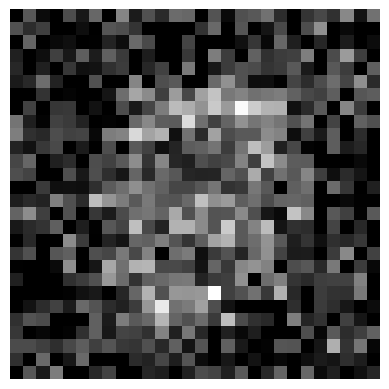

Step 10
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9987 - val_loss: 1.4305e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.914499  -10.145532 ]
 [  7.9145017 -10.145536 ]
 [  7.914497  -10.145529 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0215 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.144896   6.1932616]
 [-8.144897   6.1932635]
 [-8.144894   6.1932607]], shape=(3, 2), dtype=float32)


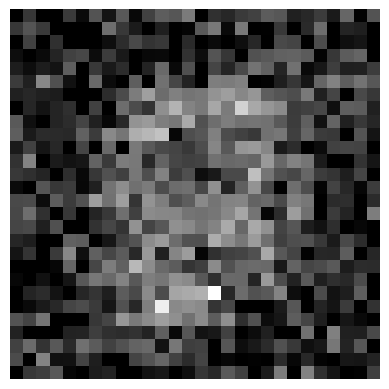

Step 11
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9966 - val_loss: 2.0266e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.0147753 -9.730469 ]
 [ 7.014774  -9.730467 ]
 [ 7.0147743 -9.730468 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.030016   6.4445796]
 [-8.030016   6.4445796]
 [-8.030021   6.4445834]], shape=(3, 2), dtype=float32)


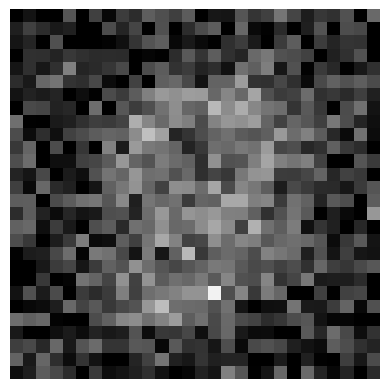

Step 12
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9971 - val_loss: 3.2187e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.0348167 -9.655361 ]
 [ 7.034816  -9.655358 ]
 [ 7.034816  -9.655359 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.9223647  6.4611564]
 [-7.922364   6.461156 ]
 [-7.922364   6.461156 ]], shape=(3, 2), dtype=float32)


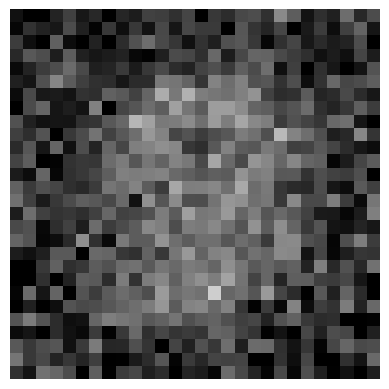

Step 13
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9970 - val_loss: 1.9073e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.779742  -9.872122 ]
 [ 6.7797422 -9.872122 ]
 [ 6.779741  -9.87212  ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.8282413  6.368963 ]
 [-7.8282347  6.3689575]
 [-7.8282433  6.368964 ]], shape=(3, 2), dtype=float32)


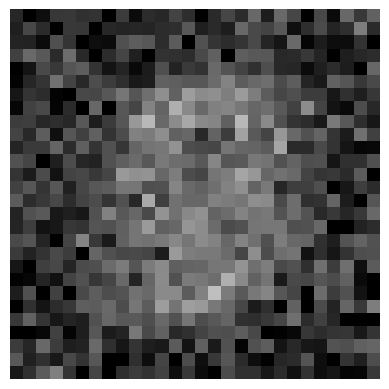

Step 14
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0138 - sparse_categorical_accuracy: 0.9976 - val_loss: 9.1791e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.558912  -8.9108515]
 [ 7.5589137 -8.910854 ]
 [ 7.5589175 -8.910858 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0198 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.714214   6.490678 ]
 [-7.714215   6.4906797]
 [-7.7142158  6.49068  ]], shape=(3, 2), dtype=float32)


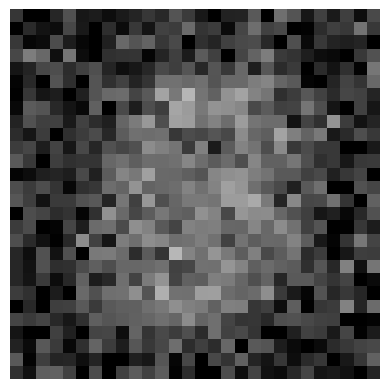

Step 15
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0266 - sparse_categorical_accuracy: 0.9959 - val_loss: 7.8678e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.7850227 -9.582023 ]
 [ 6.785023  -9.582023 ]
 [ 6.785023  -9.582022 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.5514693  6.5573363]
 [-7.5514874  6.557353 ]
 [-7.551483   6.557349 ]], shape=(3, 2), dtype=float32)


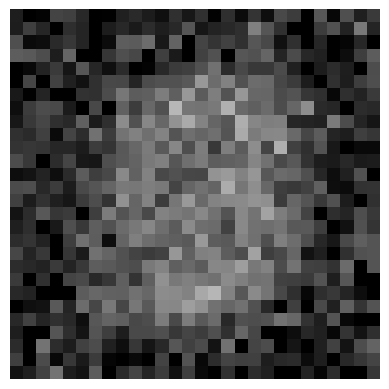

Step 16
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0115 - sparse_categorical_accuracy: 0.9971 - val_loss: 8.3446e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.3425317 -9.404838 ]
 [ 7.3425307 -9.404838 ]
 [ 7.342532  -9.404839 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.813037   6.5884247]
 [-7.8130345  6.588422 ]
 [-7.813038   6.5884256]], shape=(3, 2), dtype=float32)


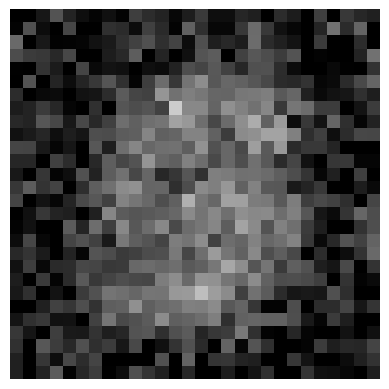

Step 17
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0154 - sparse_categorical_accuracy: 0.9957 - val_loss: 2.7418e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.711626  -9.9611845]
 [ 6.711625  -9.961184 ]
 [ 6.711627  -9.961186 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.898293   6.806089 ]
 [-7.8982735  6.8060713]
 [-7.8982754  6.806073 ]], shape=(3, 2), dtype=float32)


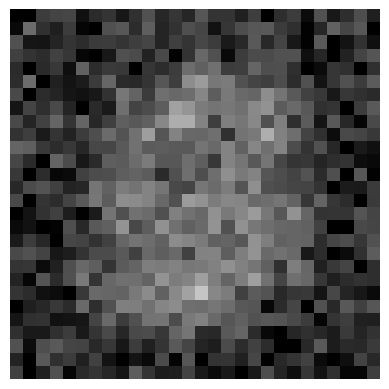

Step 18
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9976 - val_loss: 3.5405e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.656741  -8.490937 ]
 [ 6.6567388 -8.490935 ]
 [ 6.656741  -8.490936 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0180 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.946341   6.772555 ]
 [-7.9463425  6.772556 ]
 [-7.946343   6.7725563]], shape=(3, 2), dtype=float32)


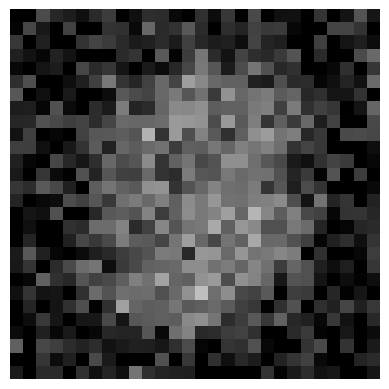

Step 19
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9986 - val_loss: 3.0994e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.3215785 -9.339745 ]
 [ 7.3215795 -9.339746 ]
 [ 7.321578  -9.339745 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0198 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.052527  6.707724]
 [-8.052532  6.707727]
 [-8.05254   6.707734]], shape=(3, 2), dtype=float32)


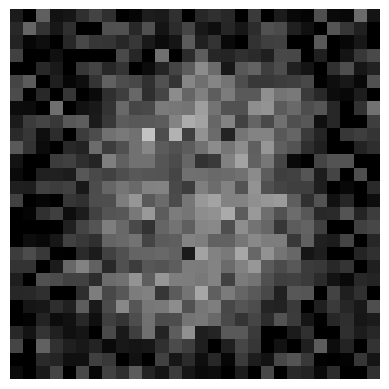

Step 20
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9980 - val_loss: 1.5497e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.040467 -8.776785]
 [ 8.040476 -8.776794]
 [ 8.04047  -8.776788]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-11.750224  11.147434]
 [-11.75022   11.147432]
 [-11.750219  11.147431]], shape=(3, 2), dtype=float32)


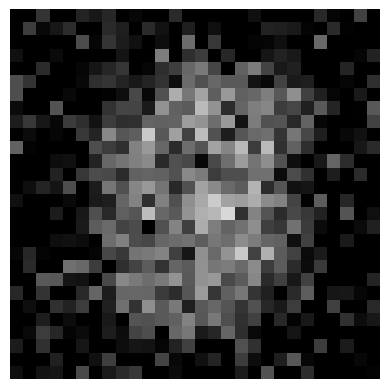

Step 21
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0370 - sparse_categorical_accuracy: 0.9963 - val_loss: 6.1989e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.903892  -8.826272 ]
 [ 6.9038925 -8.826272 ]
 [ 6.903892  -8.826272 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.821454   7.749119 ]
 [-7.821453   7.7491174]
 [-7.821452   7.749117 ]], shape=(3, 2), dtype=float32)


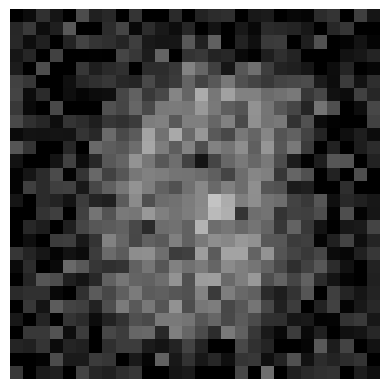

Step 22
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9982 - val_loss: 5.7220e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.2574615 -9.080908 ]
 [ 7.2574615 -9.080908 ]
 [ 7.2574606 -9.080908 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0195 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.4123974  7.48359  ]
 [-7.4124002  7.4835935]
 [-7.412396   7.4835887]], shape=(3, 2), dtype=float32)


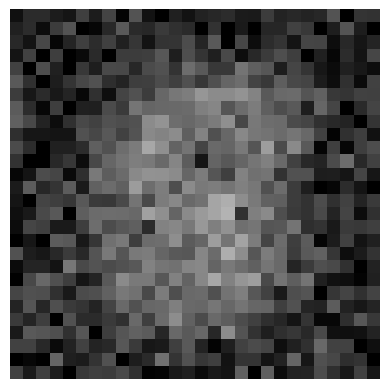

Step 23
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0126 - sparse_categorical_accuracy: 0.9976 - val_loss: 1.2636e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.4725513 -8.881892 ]
 [ 6.4725513 -8.881892 ]
 [ 6.472551  -8.881892 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0183 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.567133   7.620747 ]
 [-7.567128   7.6207423]
 [-7.567131   7.6207447]], shape=(3, 2), dtype=float32)


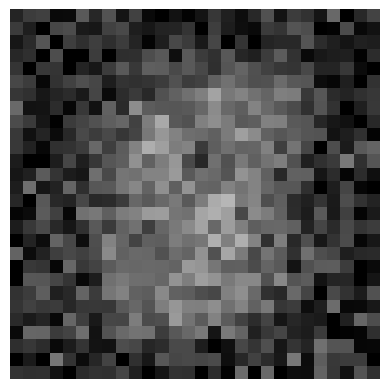

Step 24
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9983 - val_loss: 2.9444e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.6558743 -9.01127  ]
 [ 6.655874  -9.01127  ]
 [ 6.655874  -9.01127  ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.59581   9.932071]
 [-9.595809  9.932068]
 [-9.595811  9.932071]], shape=(3, 2), dtype=float32)


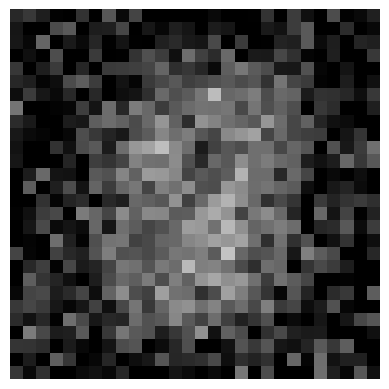

Step 25
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0166 - sparse_categorical_accuracy: 0.9966 - val_loss: 6.3181e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.5094786 -9.110447 ]
 [ 6.5094786 -9.110447 ]
 [ 6.5094776 -9.110447 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.689951 10.204835]
 [-9.689949 10.204832]
 [-9.689949 10.204834]], shape=(3, 2), dtype=float32)


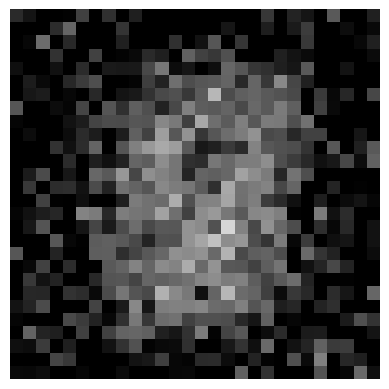

Step 26
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0153 - sparse_categorical_accuracy: 0.9980 - val_loss: 7.0333e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.3124633 -9.618931 ]
 [ 6.3124633 -9.618931 ]
 [ 6.3124633 -9.618931 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.49776    7.7753587]
 [-7.49776    7.7753596]
 [-7.4977603  7.7753596]], shape=(3, 2), dtype=float32)


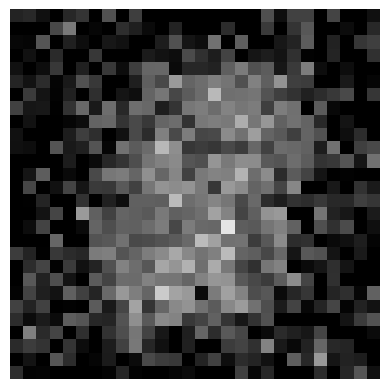

Step 27
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0068 - sparse_categorical_accuracy: 0.9992 - val_loss: 4.0531e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.537245  -9.888364 ]
 [ 7.537244  -9.888363 ]
 [ 7.5372415 -9.888359 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.7775946  8.010738 ]
 [-7.7775955  8.010739 ]
 [-7.7775974  8.010741 ]], shape=(3, 2), dtype=float32)


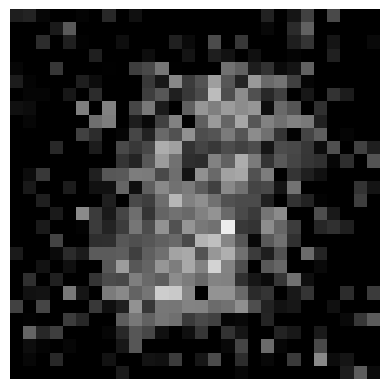

Step 28
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9984 - val_loss: 6.0797e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.685965 -9.232504]
 [ 6.685965 -9.232503]
 [ 6.685965 -9.232504]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.5618925  10.77691  ]
 [-10.561895   10.776911 ]
 [-10.561894   10.77691  ]], shape=(3, 2), dtype=float32)


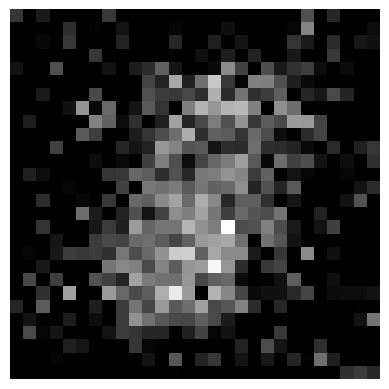

Step 29
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9992 - val_loss: 1.6689e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.472336  -10.4503765]
 [  7.472332  -10.450373 ]
 [  7.472335  -10.4503765]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-17.230463  17.563566]
 [-17.230463  17.563566]
 [-17.230461  17.563564]], shape=(3, 2), dtype=float32)


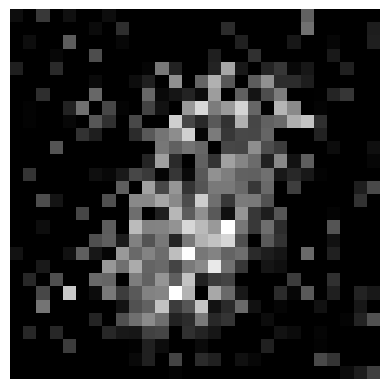

Step 30
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0193 - sparse_categorical_accuracy: 0.9971 - val_loss: 5.3644e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.536627  -10.279299 ]
 [  6.5366263 -10.279299 ]
 [  6.5366282 -10.279301 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.7017975  9.585973 ]
 [-9.701795   9.585969 ]
 [-9.701797   9.585972 ]], shape=(3, 2), dtype=float32)


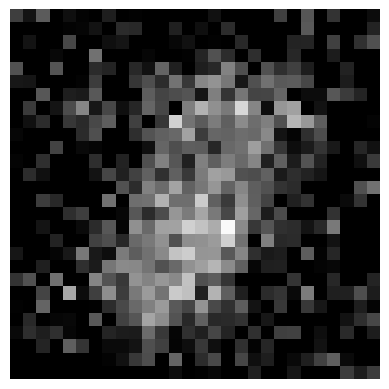

Step 31
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9986 - val_loss: 4.1723e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.1940885 -10.187211 ]
 [  7.1940866 -10.187209 ]
 [  7.1940856 -10.187207 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-12.408115   12.10279  ]
 [-12.4081135  12.102789 ]
 [-12.408117   12.10279  ]], shape=(3, 2), dtype=float32)


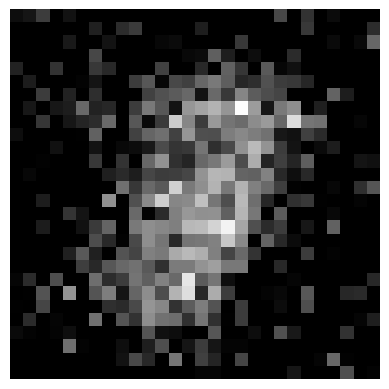

Step 32
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9980 - val_loss: 1.3113e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.3921046 -10.365248 ]
 [  6.3921037 -10.365247 ]
 [  6.3921056 -10.365249 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.274747  9.39424 ]
 [-9.274747  9.394241]
 [-9.274747  9.39424 ]], shape=(3, 2), dtype=float32)


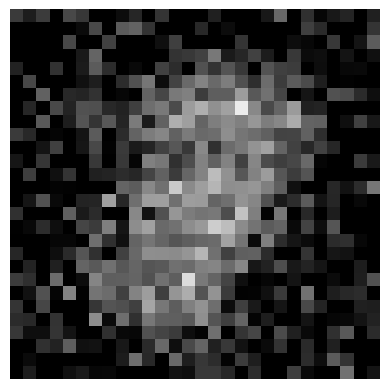

Step 33
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0124 - sparse_categorical_accuracy: 0.9987 - val_loss: 4.7684e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.0478525 -10.686216 ]
 [  6.0478516 -10.686216 ]
 [  6.0478516 -10.686216 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.574152   7.390522 ]
 [-7.574154   7.3905225]
 [-7.574148   7.390517 ]], shape=(3, 2), dtype=float32)


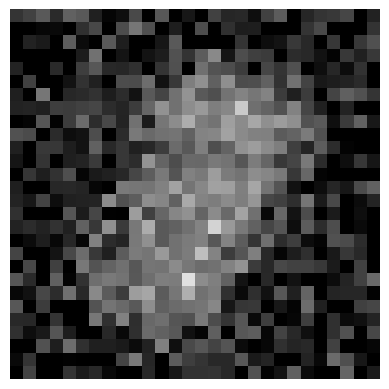

Step 34
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9986 - val_loss: 5.9605e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.3011546 -10.263168 ]
 [  6.3011546 -10.263168 ]
 [  6.3011546 -10.263168 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.7815967  7.4613504]
 [-7.781593   7.4613476]
 [-7.7815967  7.4613504]], shape=(3, 2), dtype=float32)


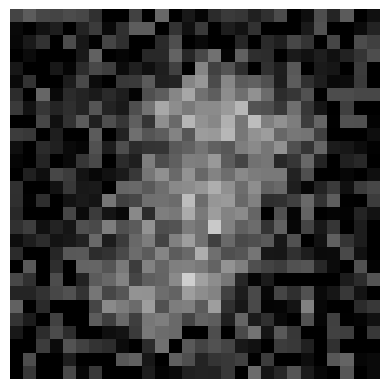

Step 35
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.9983 - val_loss: 1.1206e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.7464995 -11.671602 ]
 [  7.746498  -11.671602 ]
 [  7.746496  -11.671598 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0231 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-16.331045  15.875744]
 [-16.331045  15.875746]
 [-16.331045  15.875745]], shape=(3, 2), dtype=float32)


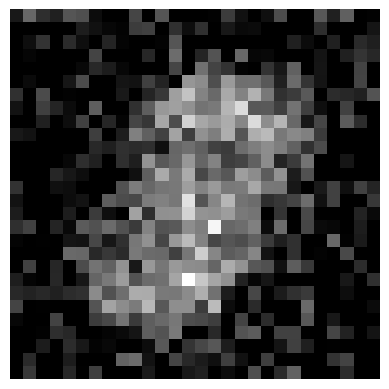

Step 36
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.7248464 -10.209402 ]
 [  6.724847  -10.209402 ]
 [  6.724847  -10.209402 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-11.480998  10.790827]
 [-11.480998  10.790827]
 [-11.480998  10.790827]], shape=(3, 2), dtype=float32)


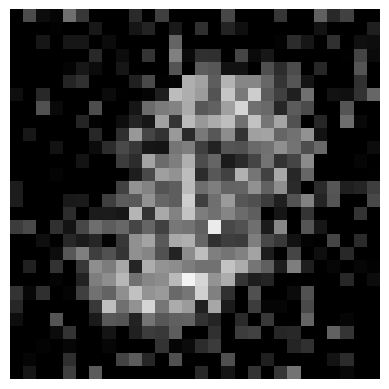

Step 37
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9983 - val_loss: 5.7220e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.3897123 -10.111589 ]
 [  6.3897123 -10.11159  ]
 [  6.3897142 -10.11159  ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.116563   6.932689 ]
 [-8.116564   6.93269  ]
 [-8.116564   6.9326897]], shape=(3, 2), dtype=float32)


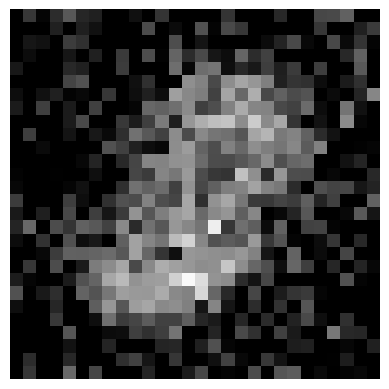

Step 38
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9984 - val_loss: 9.0599e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.5782313 -10.245911 ]
 [  6.5782313 -10.245912 ]
 [  6.57823   -10.24591  ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.492015  6.662376]
 [-8.492014  6.662375]
 [-8.492011  6.662373]], shape=(3, 2), dtype=float32)


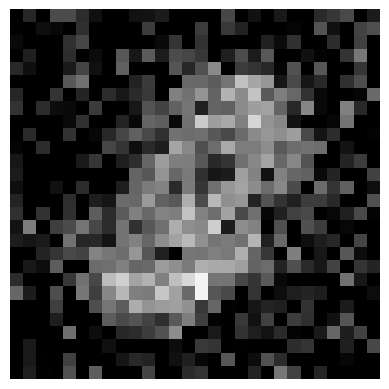

Step 39
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0114 - sparse_categorical_accuracy: 0.9982 - val_loss: 6.0797e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.3739786 -10.180375 ]
 [  6.3739767 -10.180373 ]
 [  6.3739777 -10.180374 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.450988   6.805063 ]
 [-8.450994   6.8050685]
 [-8.450982   6.805059 ]], shape=(3, 2), dtype=float32)


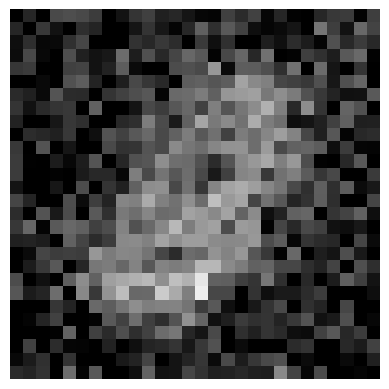

Step 40
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.5872765 -11.059398 ]
 [  7.5872803 -11.059405 ]
 [  7.587282  -11.059407 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0222 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-11.958838    9.125333 ]
 [-11.9588375   9.125332 ]
 [-11.958839    9.125333 ]], shape=(3, 2), dtype=float32)


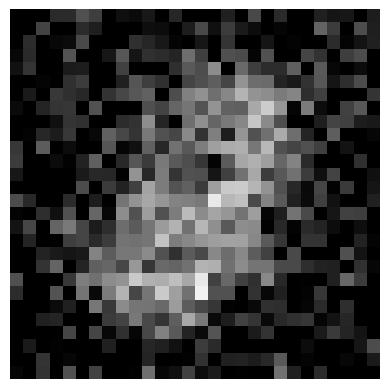

Step 41
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9981 - val_loss: 9.5367e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.712038 -10.323171]
 [  6.712037 -10.323169]
 [  6.712037 -10.323169]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.94493    8.152697]
 [-10.944931   8.152697]
 [-10.944929   8.152697]], shape=(3, 2), dtype=float32)


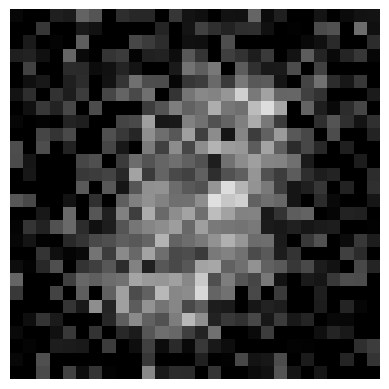

Step 42
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0180 - sparse_categorical_accuracy: 0.9986 - val_loss: 1.4305e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  8.062635 -11.489958]
 [  8.062642 -11.489967]
 [  8.062636 -11.48996 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0233 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-13.583143    9.092    ]
 [-13.58316     9.0920105]
 [-13.583145    9.092002 ]], shape=(3, 2), dtype=float32)


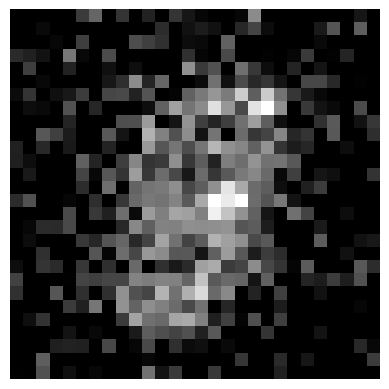

Step 43
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.506656  -10.378524 ]
 [  6.5066576 -10.378526 ]
 [  6.5066576 -10.378525 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.587313   6.9113736]
 [-9.587309   6.9113717]
 [-9.587311   6.9113727]], shape=(3, 2), dtype=float32)


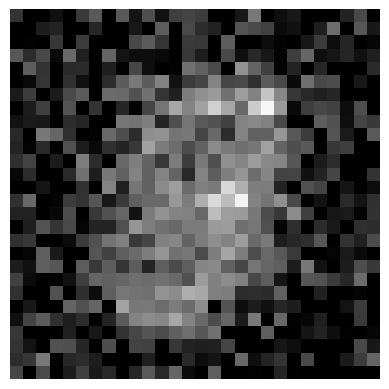

Step 44
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0058 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.194822  -10.928605 ]
 [  7.19482   -10.928603 ]
 [  7.1948195 -10.928603 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.860696   6.6156178]
 [-8.860698   6.6156197]
 [-8.860696   6.615617 ]], shape=(3, 2), dtype=float32)


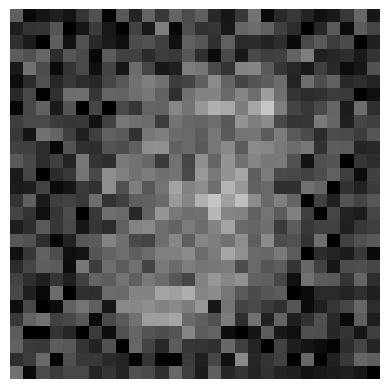

Step 45
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9986 - val_loss: 1.1921e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.4113574 -10.350983 ]
 [  7.411356  -10.350981 ]
 [  7.411357  -10.350983 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.928195   7.0439277]
 [-8.928618   7.0442605]
 [-8.92843    7.0441117]], shape=(3, 2), dtype=float32)


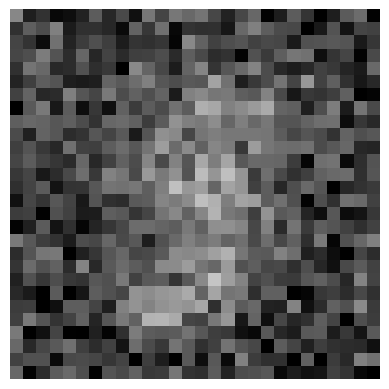

Step 46
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9988 - val_loss: 2.3842e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.29376   -9.457039 ]
 [ 7.293756  -9.457034 ]
 [ 7.2937665 -9.457048 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-18.070295   15.0440035]
 [-18.070993   15.044585 ]
 [-18.07099    15.044583 ]], shape=(3, 2), dtype=float32)


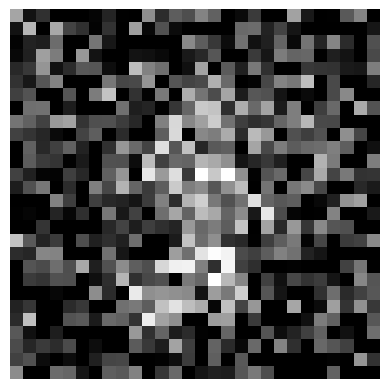

Step 47
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9990 - val_loss: 2.3842e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.7058134 -9.783906 ]
 [ 7.706053  -9.784214 ]
 [ 7.7058115 -9.783903 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0208 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-63.04682   50.414783]
 [-63.063694  50.428276]
 [-63.0573    50.423172]], shape=(3, 2), dtype=float32)


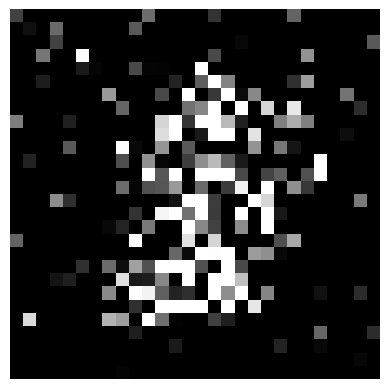

Step 48
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9969 - val_loss: 5.9605e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  6.659209  -11.277362 ]
 [  6.657428  -11.274272 ]
 [  6.656603  -11.2728405]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-21.480797  16.740597]
 [-21.48191   16.74146 ]
 [-21.480938  16.74071 ]], shape=(3, 2), dtype=float32)


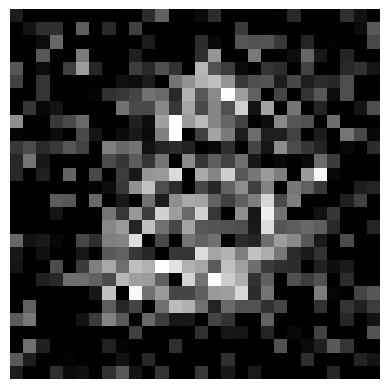

Step 49
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0125 - sparse_categorical_accuracy: 0.9990 - val_loss: 3.5763e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  7.2228317 -10.507007 ]
 [  7.22281   -10.506973 ]
 [  7.2228093 -10.506974 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0211 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.882969   6.6302505]
 [-8.882854   6.6301646]
 [-8.882996   6.6302705]], shape=(3, 2), dtype=float32)


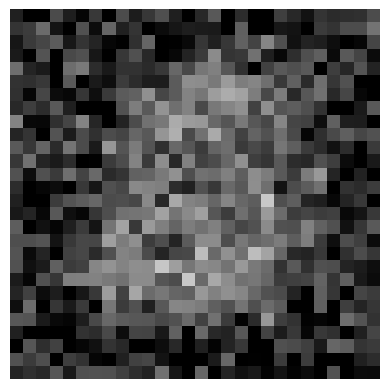

Step 50
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9952 - val_loss: 4.7684e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.2853513 -9.428665 ]
 [ 7.285352  -9.428665 ]
 [ 7.2853484 -9.428659 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.648854   6.7613835]
 [-8.648938   6.7614493]
 [-8.648774   6.7613206]], shape=(3, 2), dtype=float32)


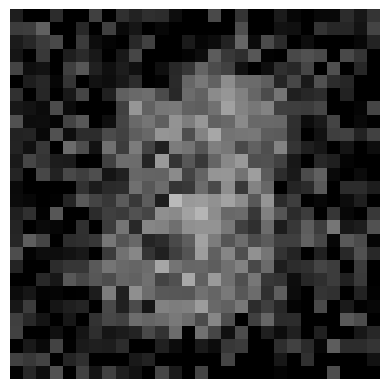

Step 51
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0182 - sparse_categorical_accuracy: 0.9989 - val_loss: 1.9073e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  9.898615 -12.435949]
 [  9.89868  -12.436032]
 [  9.898631 -12.435968]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0266 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-19.10528   15.556929]
 [-19.105513  15.557117]
 [-19.10531   15.556953]], shape=(3, 2), dtype=float32)


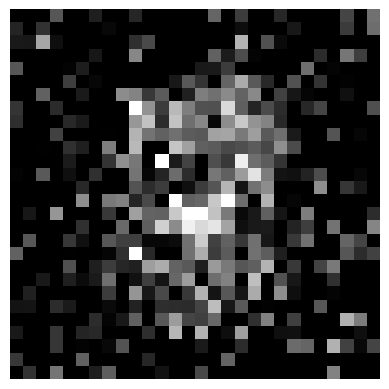

Step 52
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0094 - sparse_categorical_accuracy: 0.9992 - val_loss: 7.2718e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.409617  -9.158306 ]
 [ 7.4096165 -9.158305 ]
 [ 7.409623  -9.158314 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.476688    7.6461134]
 [-10.476661    7.6460934]
 [-10.476274    7.645808 ]], shape=(3, 2), dtype=float32)


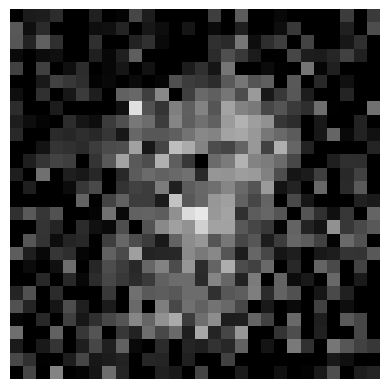

Step 53
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9964 - val_loss: 7.0333e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.0505157 -8.593521 ]
 [ 7.0505023 -8.593505 ]
 [ 7.050523  -8.593531 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.813728   6.7820907]
 [-8.813746   6.7821045]
 [-8.813729   6.7820907]], shape=(3, 2), dtype=float32)


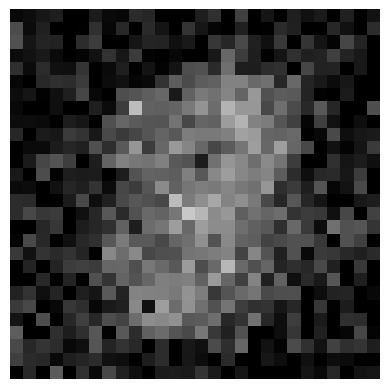

Step 54
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9969 - val_loss: 3.5763e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  9.35488   -11.435443 ]
 [  9.354878  -11.43544  ]
 [  9.3548765 -11.435438 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0252 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.727331   6.1007905]
 [-8.727331   6.1007905]
 [-8.727327   6.100787 ]], shape=(3, 2), dtype=float32)


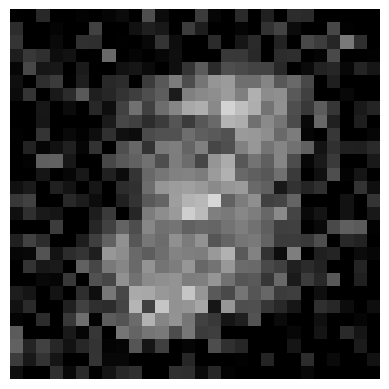

Step 55
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9975 - val_loss: 7.8678e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.4944386 -9.325612 ]
 [ 7.4944386 -9.325614 ]
 [ 7.4944425 -9.325618 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.989652   5.9020524]
 [-8.9896555  5.9020553]
 [-8.989652   5.9020524]], shape=(3, 2), dtype=float32)


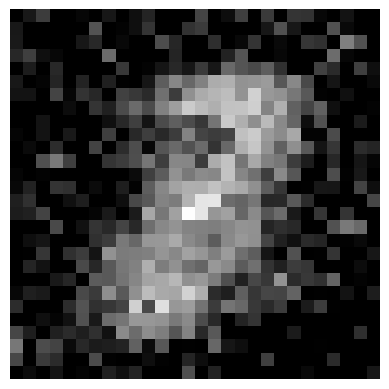

Step 56
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0238 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 11.066073  -13.031958 ]
 [ 11.0660715 -13.031955 ]
 [ 11.066073  -13.031957 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0287 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.165728   6.1938224]
 [-9.16573    6.1938233]
 [-9.165727   6.193821 ]], shape=(3, 2), dtype=float32)


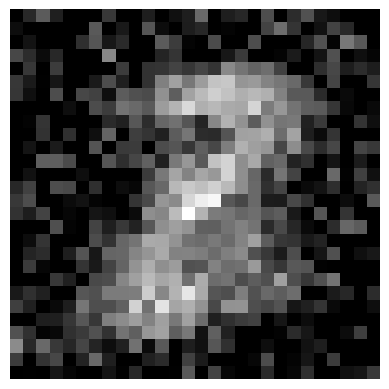

Step 57
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0153 - sparse_categorical_accuracy: 0.9987 - val_loss: 1.1206e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.6260657 -8.936041 ]
 [ 7.6260667 -8.936044 ]
 [ 7.626066  -8.936042 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.562886  5.769486]
 [-9.562886  5.769488]
 [-9.562888  5.76949 ]], shape=(3, 2), dtype=float32)


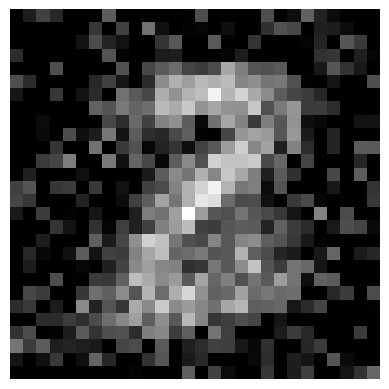

Step 58
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0273 - sparse_categorical_accuracy: 0.9978 - val_loss: 1.1683e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.1784077 -8.28343  ]
 [ 7.1784077 -8.28343  ]
 [ 7.178409  -8.283432 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0184 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-13.9605665   9.038257 ]
 [-13.960585    9.038269 ]
 [-13.960564    9.038255 ]], shape=(3, 2), dtype=float32)


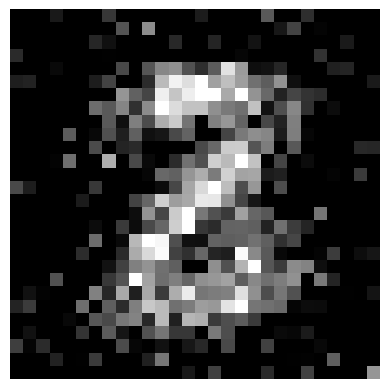

Step 59
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9973 - val_loss: 1.9670e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.7575493 -8.006119 ]
 [ 6.75755   -8.006119 ]
 [ 6.7575483 -8.006117 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.680462   6.0743017]
 [-9.680466   6.074304 ]
 [-9.680449   6.0742927]], shape=(3, 2), dtype=float32)


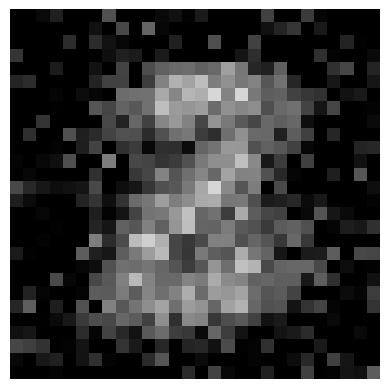

Step 60
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9981 - val_loss: 4.1723e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.763588  -9.071093 ]
 [ 7.7635865 -9.071092 ]
 [ 7.763588  -9.071094 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-13.143625   8.193766]
 [-13.143627   8.193768]
 [-13.143626   8.193767]], shape=(3, 2), dtype=float32)


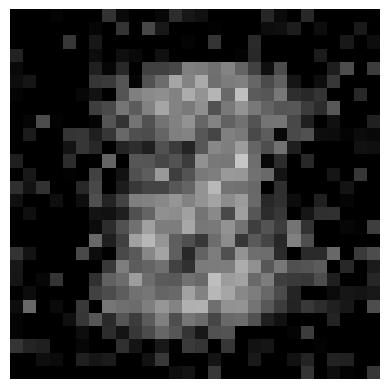

Step 61
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.0348964 -9.761235 ]
 [ 7.03489   -9.761226 ]
 [ 7.034901  -9.761243 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.001792    7.1913586]
 [-10.001787    7.1913548]
 [-10.001787    7.191355 ]], shape=(3, 2), dtype=float32)


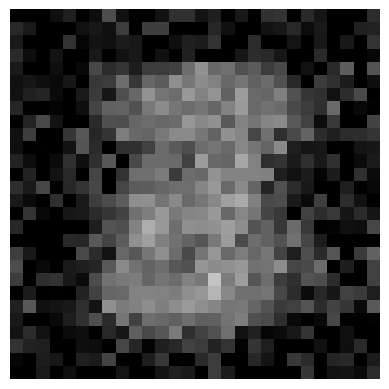

Step 62
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0350 - sparse_categorical_accuracy: 0.9948 - val_loss: 1.4305e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 12.834792 -16.50381 ]
 [ 12.834792 -16.503809]
 [ 12.834791 -16.503809]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0382 - sparse_categorical_accuracy: 0.9976
Discriminator on random data after training generator:
tf.Tensor(
[[-17.702963   12.735743 ]
 [-17.702965   12.7357435]
 [-17.702963   12.735742 ]], shape=(3, 2), dtype=float32)


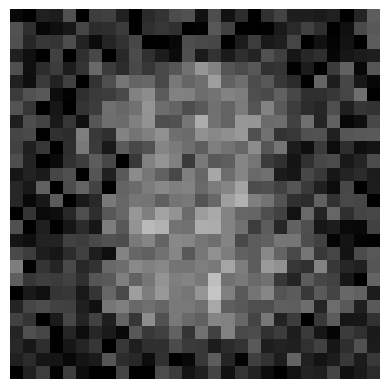

Step 63
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.667992 -9.124558]
 [ 7.667992 -9.124558]
 [ 7.667992 -9.124557]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.992395   6.9330993]
 [-8.992397   6.9331026]
 [-8.992399   6.9331026]], shape=(3, 2), dtype=float32)


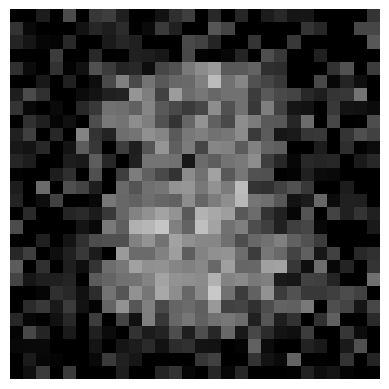

Step 64
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0145 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 12.443659 -16.15575 ]
 [ 12.443659 -16.15575 ]
 [ 12.443659 -16.155752]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9976
Discriminator on random data after training generator:
tf.Tensor(
[[-18.50868   16.234037]
 [-18.50867   16.23403 ]
 [-18.508675  16.234034]], shape=(3, 2), dtype=float32)


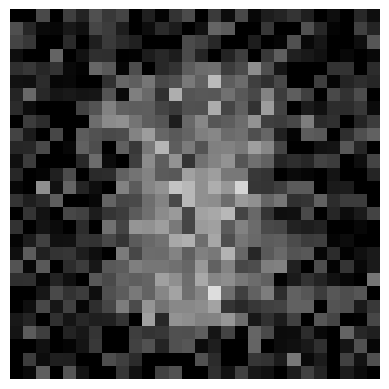

Step 65
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 11.916096 -15.349466]
 [ 11.916095 -15.349464]
 [ 11.916097 -15.349466]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0325 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.194096   7.8020773]
 [-8.194096   7.8020773]
 [-8.194093   7.8020744]], shape=(3, 2), dtype=float32)


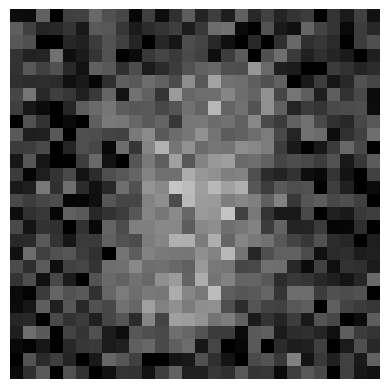

Step 66
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  8.042187 -10.312475]
 [  8.042187 -10.312475]
 [  8.042187 -10.312477]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-13.15657    12.329346 ]
 [-13.1565695  12.329346 ]
 [-13.156569   12.329346 ]], shape=(3, 2), dtype=float32)


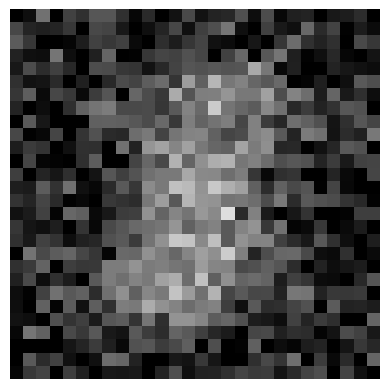

Step 67
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.3670363 -9.82204  ]
 [ 7.3670382 -9.822042 ]
 [ 7.367037  -9.82204  ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 8ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-19.78871   19.544838]
 [-19.78871   19.544834]
 [-19.7887    19.544827]], shape=(3, 2), dtype=float32)


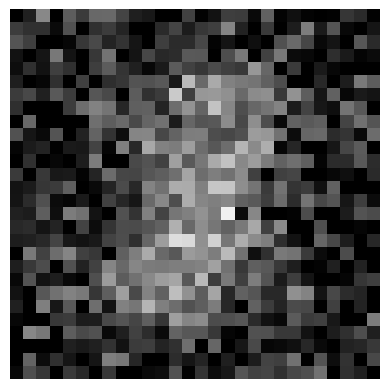

Step 68
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0145 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 10.981458 -13.884084]
 [ 10.981455 -13.884081]
 [ 10.981458 -13.884084]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-14.961444   15.300182 ]
 [-14.9614725  15.300212 ]
 [-14.961426   15.300164 ]], shape=(3, 2), dtype=float32)


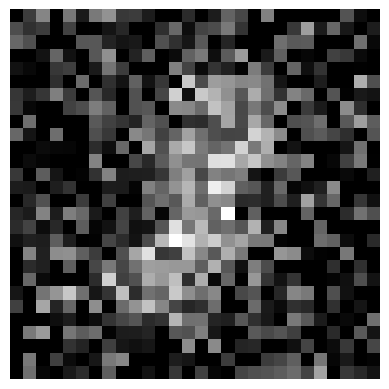

Step 69
Training discriminator
8400
8400
1660/1660 [==============================] - 8s 5ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9975 - val_loss: 1.1563e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.1056247 -8.423322 ]
 [ 7.1056314 -8.423329 ]
 [ 7.1056314 -8.423329 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-25.888525  27.411095]
 [-25.887995  27.410534]
 [-25.888365  27.410927]], shape=(3, 2), dtype=float32)


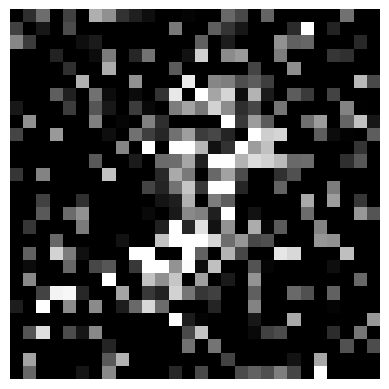

Step 70
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  9.000747 -10.703023]
 [  9.00076  -10.703036]
 [  9.000764 -10.70304 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 8ms/step - loss: 0.0235 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-47.677216  50.506695]
 [-47.68125   50.510975]
 [-47.680626  50.51031 ]], shape=(3, 2), dtype=float32)


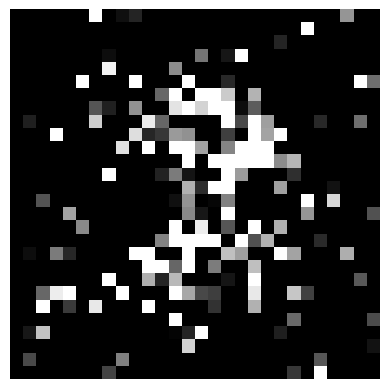

Step 71
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9983 - val_loss: 4.7684e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 11.88187  -15.845947]
 [ 11.881972 -15.84601 ]
 [ 11.881894 -15.845981]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-187.96803  199.71638]
 [-187.93965  199.68626]
 [-188.06778  199.82233]], shape=(3, 2), dtype=float32)


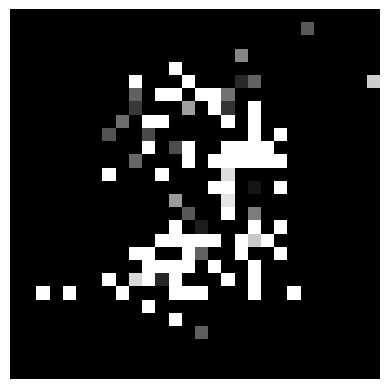

Step 72
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.2062 - sparse_categorical_accuracy: 0.9911 - val_loss: 1.5497e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 15.13038  -15.164474]
 [ 15.132481 -15.166472]
 [ 15.140408 -15.174027]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 8ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-33.827534  32.601887]
 [-33.82636   32.600754]
 [-33.82624   32.600643]], shape=(3, 2), dtype=float32)


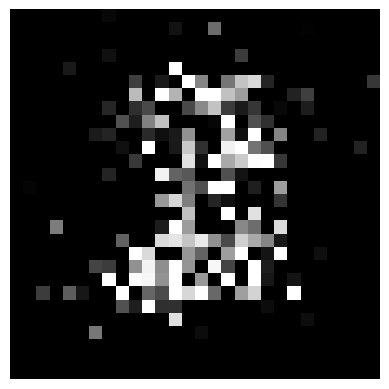

Step 73
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0351 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.758827  -8.515943 ]
 [ 8.7587805 -8.515901 ]
 [ 8.758443  -8.515578 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0206 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-13.838519   14.019653 ]
 [-13.838521   14.019657 ]
 [-13.8385935  14.019728 ]], shape=(3, 2), dtype=float32)


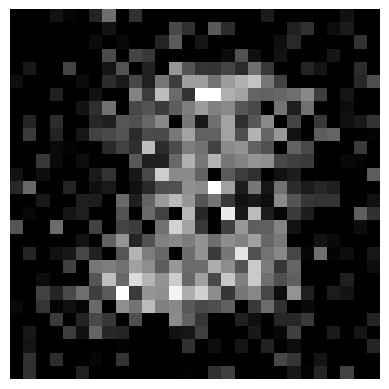

Step 74
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0138 - sparse_categorical_accuracy: 0.9977 - val_loss: 1.7820e-06 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.775481  -7.205029 ]
 [ 9.77551   -7.2050505]
 [ 9.775516  -7.2050543]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.2281485  7.976475 ]
 [-7.228154   7.9764805]
 [-7.2281647  7.976492 ]], shape=(3, 2), dtype=float32)


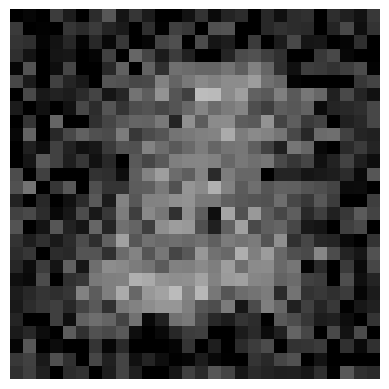

Step 75
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0084 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.918042  -7.029155 ]
 [ 9.918048  -7.0291586]
 [ 9.918054  -7.0291615]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.5934534  8.04329  ]
 [-7.5934386  8.043276 ]
 [-7.59344    8.043277 ]], shape=(3, 2), dtype=float32)


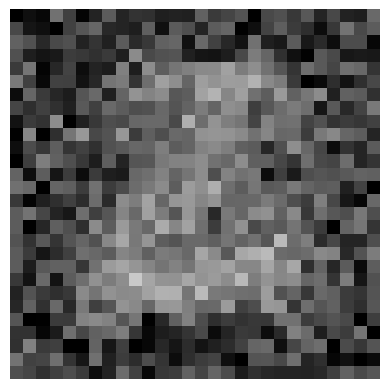

Step 76
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0081 - sparse_categorical_accuracy: 0.9989 - val_loss: 6.7949e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.3936    -6.6128354]
 [ 9.393598  -6.6128335]
 [ 9.393599  -6.6128345]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.7851763  7.9211435]
 [-7.7851872  7.9211545]
 [-7.7851796  7.921147 ]], shape=(3, 2), dtype=float32)


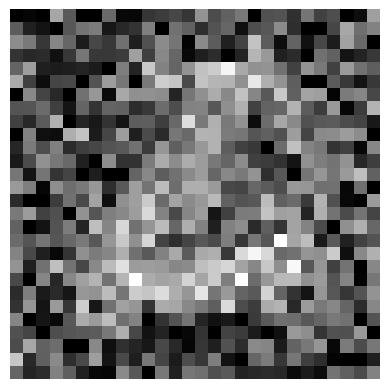

Step 77
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.969258  -9.0067005]
 [ 7.969253  -9.006695 ]
 [ 7.969255  -9.006698 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.5257773  7.9522886]
 [-7.52578    7.9522915]
 [-7.525782   7.9522924]], shape=(3, 2), dtype=float32)


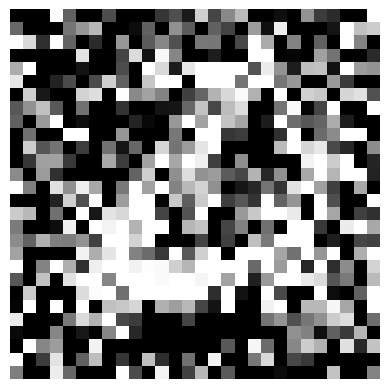

Step 78
Training discriminator
8400
8400
1660/1660 [==============================] - 8s 5ms/step - loss: 0.0075 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 13.248725 -15.720907]
 [ 13.248729 -15.720912]
 [ 13.248726 -15.720909]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.1688 - sparse_categorical_accuracy: 0.9893
Discriminator on random data after training generator:
tf.Tensor(
[[-9.391034  9.695125]
 [-9.391031  9.695122]
 [-9.391037  9.695126]], shape=(3, 2), dtype=float32)


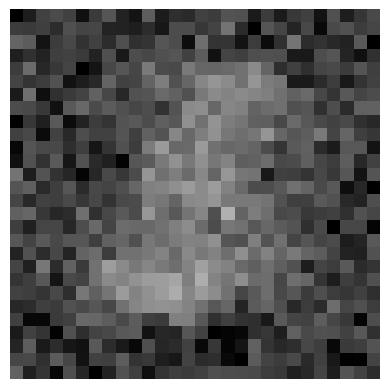

Step 79
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.856268  -8.795289 ]
 [ 7.856269  -8.795291 ]
 [ 7.8562665 -8.795287 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0198 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-8.006011   9.4048195]
 [-8.00601    9.404816 ]
 [-8.006009   9.404815 ]], shape=(3, 2), dtype=float32)


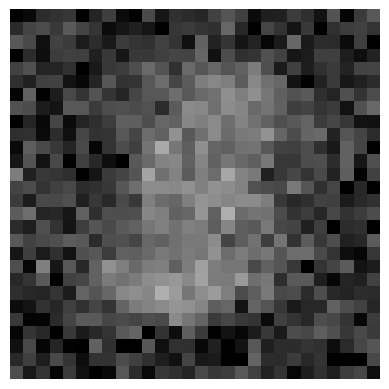

Step 80
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[10.709496  -7.079819 ]
 [10.709492  -7.079817 ]
 [10.709494  -7.0798187]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.0525537  8.501522 ]
 [-7.052555   8.501524 ]
 [-7.0525527  8.50152  ]], shape=(3, 2), dtype=float32)


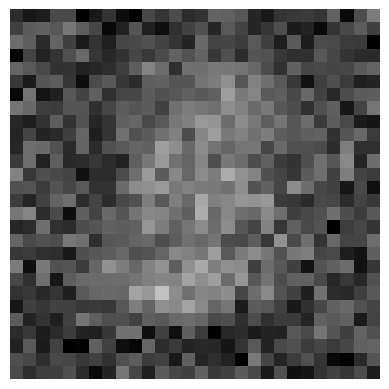

Step 81
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9983 - val_loss: 5.4836e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[10.342245  -7.689924 ]
 [10.342222  -7.689908 ]
 [10.342239  -7.6899195]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0215 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.912479  8.896606]
 [-7.912482  8.896611]
 [-7.912481  8.896608]], shape=(3, 2), dtype=float32)


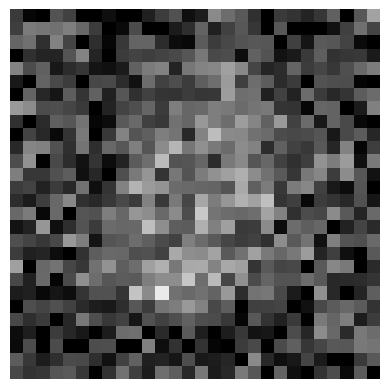

Step 82
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9998 - val_loss: 2.8610e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.107609 -8.589477]
 [ 8.10761  -8.589478]
 [ 8.107609 -8.589478]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.751349   12.123073 ]
 [-10.751345   12.123069 ]
 [-10.7513485  12.123071 ]], shape=(3, 2), dtype=float32)


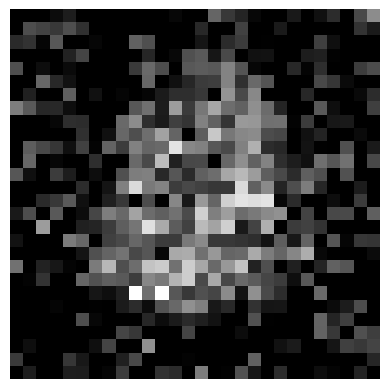

Step 83
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0148 - sparse_categorical_accuracy: 0.9988 - val_loss: 4.8398e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.098347 -8.784716]
 [ 8.098346 -8.784715]
 [ 8.098347 -8.784716]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-26.435995  30.847784]
 [-26.435907  30.847685]
 [-26.435926  30.847704]], shape=(3, 2), dtype=float32)


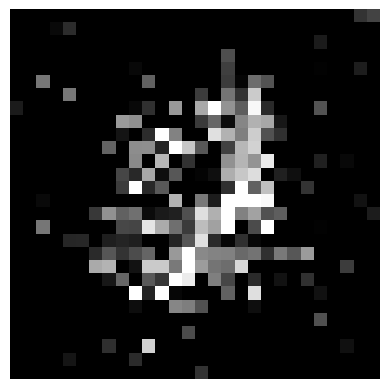

Step 84
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 5ms/step - loss: 0.0357 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[10.695147  -6.5253587]
 [10.695147  -6.525358 ]
 [10.695126  -6.525346 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-28.69661   34.721024]
 [-28.69663   34.72105 ]
 [-28.696583  34.720997]], shape=(3, 2), dtype=float32)


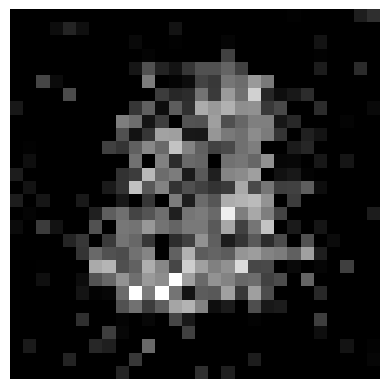

Step 85
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0661 - sparse_categorical_accuracy: 0.9969 - val_loss: 7.7486e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[10.184713  -6.561659 ]
 [10.184713  -6.5616593]
 [10.184715  -6.56166  ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-7.3489857  8.446645 ]
 [-7.3489823  8.44664  ]
 [-7.3489847  8.446645 ]], shape=(3, 2), dtype=float32)


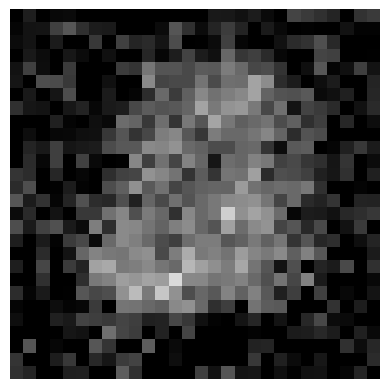

Step 86
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0178 - sparse_categorical_accuracy: 0.9957 - val_loss: 7.2021e-04 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.4592166 -6.3855667]
 [ 7.4592156 -6.385567 ]
 [ 7.4592147 -6.385566 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0168 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-13.030281   13.933451 ]
 [-13.030286   13.933457 ]
 [-13.0302925  13.933465 ]], shape=(3, 2), dtype=float32)


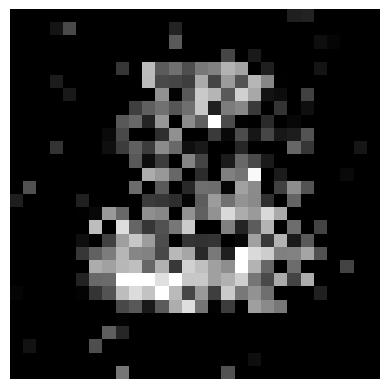

Step 87
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0238 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 16.54356  -11.288677]
 [ 16.543556 -11.288674]
 [ 16.543571 -11.288684]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-14.374271  14.250363]
 [-14.374276  14.250366]
 [-14.374272  14.250366]], shape=(3, 2), dtype=float32)


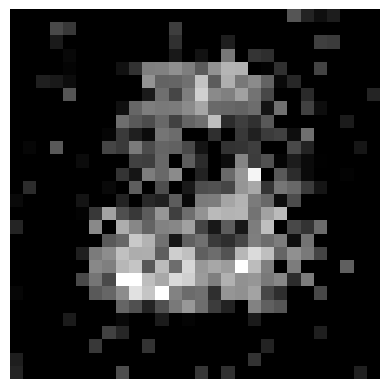

Step 88
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0386 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.91031  -9.673286]
 [ 8.910309 -9.673284]
 [ 8.910313 -9.673289]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-96.603226  99.292366]
 [-96.60328   99.292435]
 [-96.60326   99.292404]], shape=(3, 2), dtype=float32)


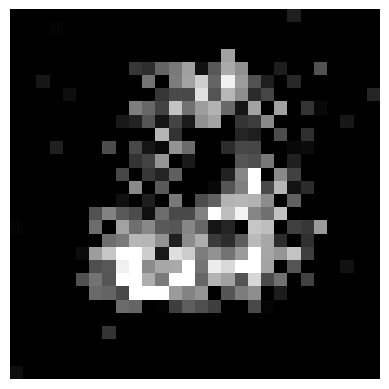

Step 89
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9976 - val_loss: 6.7949e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.285987 -8.455481]
 [ 7.285984 -8.455479]
 [ 7.285985 -8.455478]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 8ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-37.138447  19.300806]
 [-37.138447  19.300804]
 [-37.138474  19.300816]], shape=(3, 2), dtype=float32)


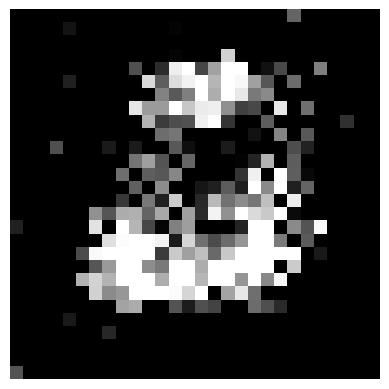

Step 90
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0246 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 23.560352 -23.87295 ]
 [ 23.560373 -23.87297 ]
 [ 23.560352 -23.872953]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-84.45186   53.92289 ]
 [-84.45187   53.922897]
 [-84.451836  53.92288 ]], shape=(3, 2), dtype=float32)


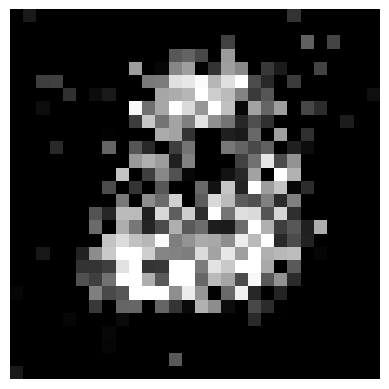

Step 91
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0684 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 19.470924 -21.294754]
 [ 19.470922 -21.294752]
 [ 19.470932 -21.294765]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.985675    5.4485397]
 [-10.985675    5.448539 ]
 [-10.985682    5.448542 ]], shape=(3, 2), dtype=float32)


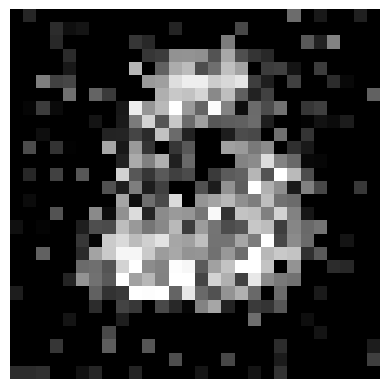

Step 92
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9987 - val_loss: 5.9605e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  8.689852 -10.278521]
 [  8.689852 -10.278521]
 [  8.689848 -10.278516]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9964
Discriminator on random data after training generator:
tf.Tensor(
[[-14.132302   8.935765]
 [-14.132298   8.935761]
 [-14.132303   8.935763]], shape=(3, 2), dtype=float32)


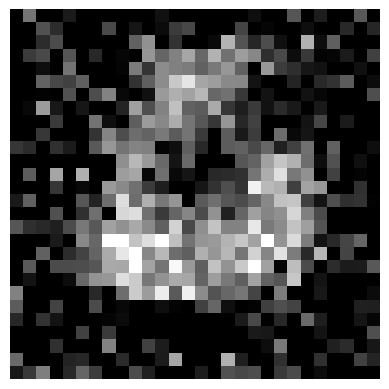

Step 93
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9977 - val_loss: 1.6332e-07 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 6.9108734 -7.9087667]
 [ 6.910874  -7.908766 ]
 [ 6.9108753 -7.9087663]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.267443    5.5110874]
 [-10.267441    5.5110855]
 [-10.267441    5.511085 ]], shape=(3, 2), dtype=float32)


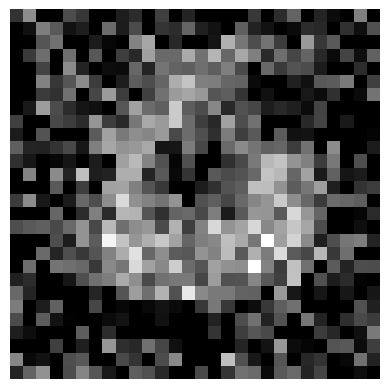

Step 94
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.010478 -9.193868]
 [ 8.010471 -9.193862]
 [ 8.010473 -9.193864]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.388643    6.425402 ]
 [-10.388641    6.4254   ]
 [-10.388636    6.4253974]], shape=(3, 2), dtype=float32)


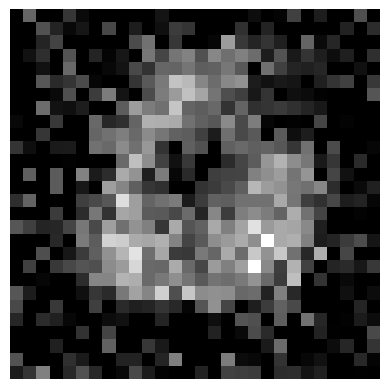

Step 95
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.823929 -8.026369]
 [ 8.823927 -8.026367]
 [ 8.823927 -8.026368]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.639104   5.8102517]
 [-9.639102   5.8102508]
 [-9.639103   5.810251 ]], shape=(3, 2), dtype=float32)


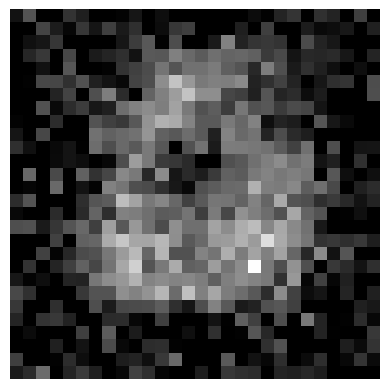

Step 96
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9981 - val_loss: 6.1989e-08 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 7.8525515 -7.919595 ]
 [ 7.852548  -7.9195924]
 [ 7.8525505 -7.9195943]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0188 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.059813   6.2040935]
 [-9.059813   6.204094 ]
 [-9.059813   6.2040935]], shape=(3, 2), dtype=float32)


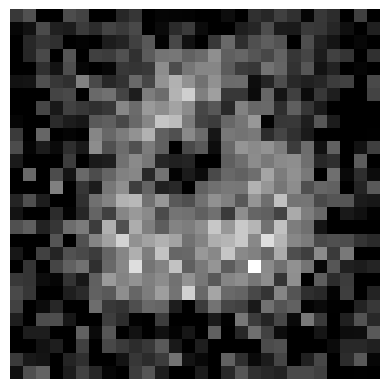

Step 97
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0136 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.451662 -8.330607]
 [ 8.451663 -8.330608]
 [ 8.451665 -8.330609]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-10.872078    7.616045 ]
 [-10.872081    7.6160483]
 [-10.872078    7.616046 ]], shape=(3, 2), dtype=float32)


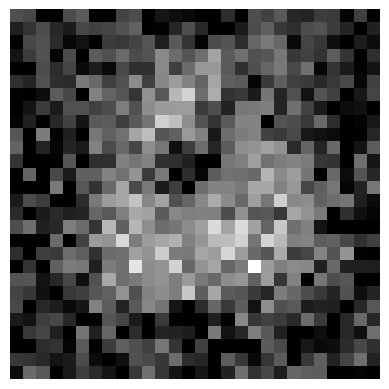

Step 98
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 11.162614  -10.4106455]
 [ 11.162619  -10.41065  ]
 [ 11.162619  -10.410651 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0257 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-36.233982  27.67573 ]
 [-36.233997  27.675735]
 [-36.23399   27.675734]], shape=(3, 2), dtype=float32)


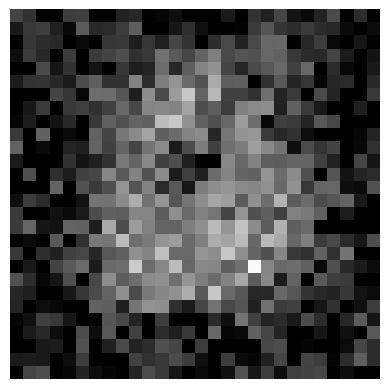

Step 99
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0286 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.400708 -9.204337]
 [ 9.400711 -9.20434 ]
 [ 9.400711 -9.204339]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-20.53266   15.45914 ]
 [-20.532661  15.45914 ]
 [-20.532665  15.459144]], shape=(3, 2), dtype=float32)


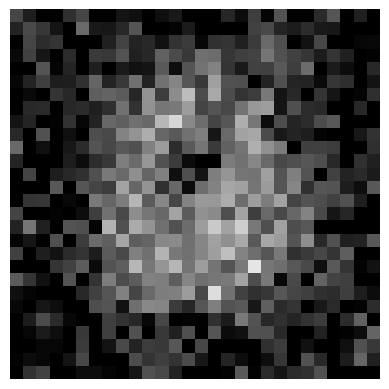

Step 100
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0261 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.912131  -8.509952 ]
 [ 8.9121275 -8.509948 ]
 [ 8.9121275 -8.509948 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-13.852463  10.547543]
 [-13.852463  10.547543]
 [-13.852463  10.547544]], shape=(3, 2), dtype=float32)


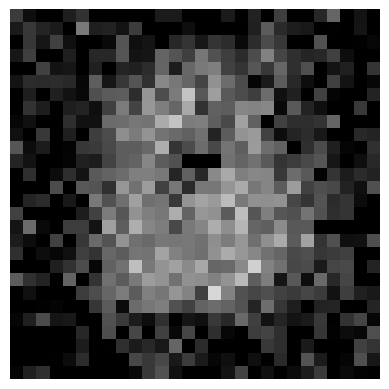

Step 101
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.860839 -8.009863]
 [ 8.860838 -8.009862]
 [ 8.860838 -8.009862]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 5s 7ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9976
Discriminator on random data after training generator:
tf.Tensor(
[[-10.854549   8.05107 ]
 [-10.854553   8.051073]
 [-10.85455    8.051071]], shape=(3, 2), dtype=float32)


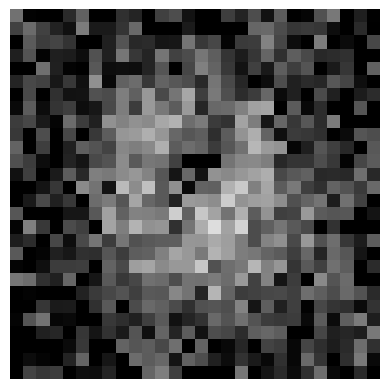

Step 102
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.038842 -8.370676]
 [ 9.038842 -8.370676]
 [ 9.038842 -8.370676]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.14015   6.518068]
 [-9.14015   6.518068]
 [-9.140147  6.518068]], shape=(3, 2), dtype=float32)


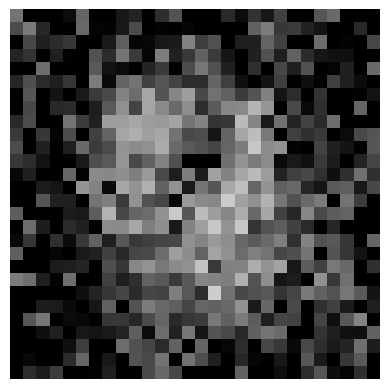

Step 103
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 10.33914  -10.571431]
 [ 10.339142 -10.571432]
 [ 10.339142 -10.571432]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0249 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-14.037972   9.487327]
 [-14.037969   9.487323]
 [-14.037977   9.48733 ]], shape=(3, 2), dtype=float32)


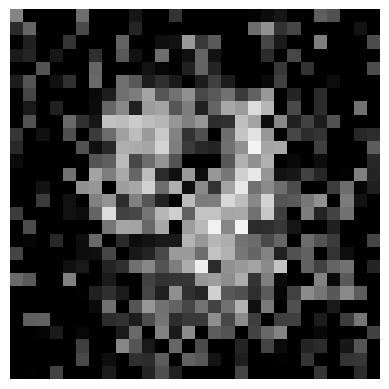

Step 104
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0148 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.145367 -8.611243]
 [ 8.145367 -8.611244]
 [ 8.145363 -8.611242]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.347907   6.7700715]
 [-9.347904   6.7700686]
 [-9.347904   6.7700686]], shape=(3, 2), dtype=float32)


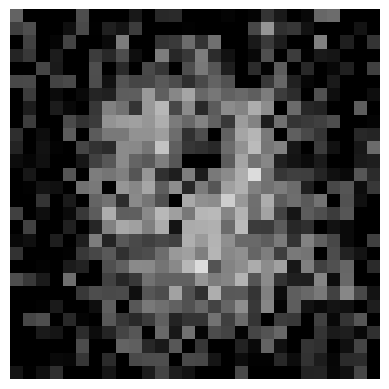

Step 105
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0079 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.544297 -8.643465]
 [ 8.544295 -8.643463]
 [ 8.544297 -8.643465]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-16.900051  14.650098]
 [-16.900043  14.650092]
 [-16.90005   14.650095]], shape=(3, 2), dtype=float32)


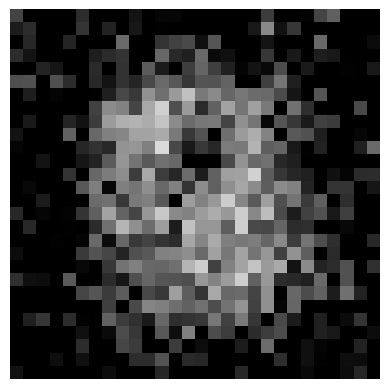

Step 106
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0314 - sparse_categorical_accuracy: 0.9964 - val_loss: 2.3842e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.214862 -8.768539]
 [ 8.214861 -8.768538]
 [ 8.214868 -8.768546]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-12.45924    8.839429]
 [-12.459241   8.839429]
 [-12.459238   8.839426]], shape=(3, 2), dtype=float32)


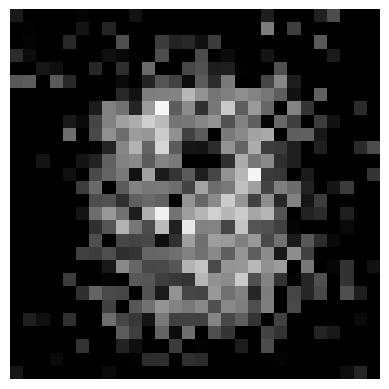

Step 107
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 10.797494 -10.501592]
 [ 10.797493 -10.501591]
 [ 10.797494 -10.501592]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0479 - sparse_categorical_accuracy: 0.9976
Discriminator on random data after training generator:
tf.Tensor(
[[-10.598003    6.0874786]
 [-10.598012    6.0874815]
 [-10.598009    6.0874805]], shape=(3, 2), dtype=float32)


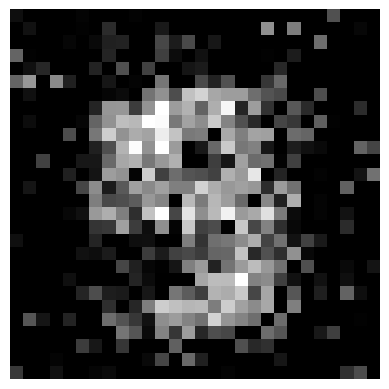

Step 108
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.14739  -8.487277]
 [ 9.147389 -8.487276]
 [ 9.147389 -8.487276]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0210 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-15.736711   10.1642885]
 [-15.7367     10.164282 ]
 [-15.736709   10.164286 ]], shape=(3, 2), dtype=float32)


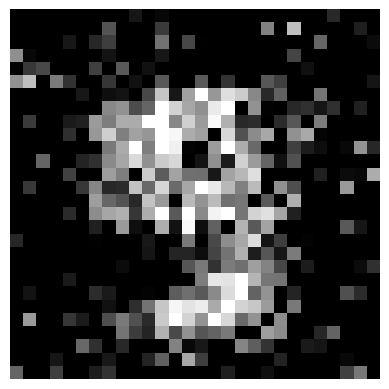

Step 109
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9988 - val_loss: 2.0872e-04 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.356203 -8.634179]
 [ 8.356201 -8.634177]
 [ 8.356201 -8.634177]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 5s 6ms/step - loss: 0.5300 - sparse_categorical_accuracy: 0.9667
Discriminator on random data after training generator:
tf.Tensor(
[[-9.216187   5.5107064]
 [-9.215868   5.5105042]
 [-9.216175   5.5106974]], shape=(3, 2), dtype=float32)


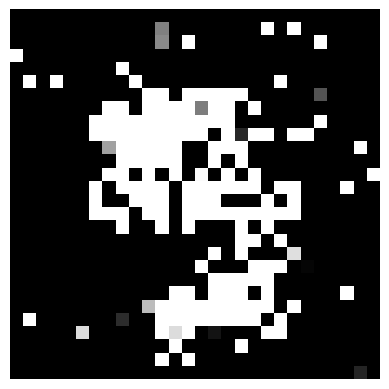

Step 110
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0037 - sparse_categorical_accuracy: 0.9996 - val_loss: 1.1921e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.221279 -9.818695]
 [ 9.22131  -9.818726]
 [ 9.2213   -9.818717]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0227 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-17.467081  10.168623]
 [-17.466925  10.16853 ]
 [-17.467001  10.168574]], shape=(3, 2), dtype=float32)


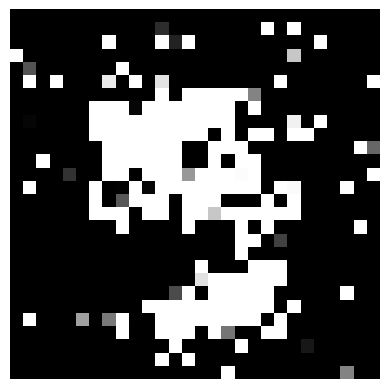

Step 111
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0033 - sparse_categorical_accuracy: 0.9999 - val_loss: 2.3842e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.471095  -9.923692 ]
 [ 9.471101  -9.9236965]
 [ 9.471109  -9.923705 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0328 - sparse_categorical_accuracy: 0.9976
Discriminator on random data after training generator:
tf.Tensor(
[[-13.251115    7.243158 ]
 [-13.251069    7.2431335]
 [-13.251114    7.24316  ]], shape=(3, 2), dtype=float32)


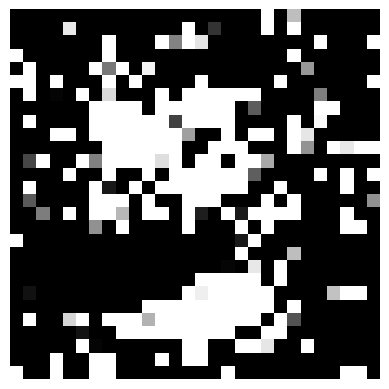

Step 112
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 16.57262  -16.606205]
 [ 16.572618 -16.606205]
 [ 16.57263  -16.60622 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0781 - sparse_categorical_accuracy: 0.9964
Discriminator on random data after training generator:
tf.Tensor(
[[-11.855223    5.1116824]
 [-11.855234    5.1116853]
 [-11.855221    5.1116824]], shape=(3, 2), dtype=float32)


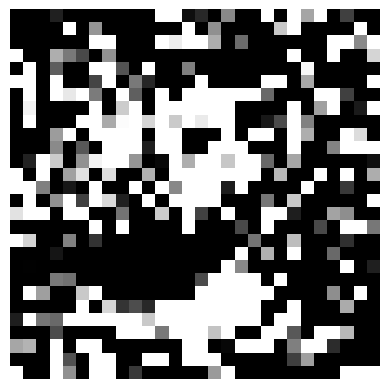

Step 113
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 10.424167 -10.341036]
 [ 10.424171 -10.341043]
 [ 10.424168 -10.34104 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 1.6969 - sparse_categorical_accuracy: 0.7095
Discriminator on random data after training generator:
tf.Tensor(
[[-51.108673  22.813255]
 [-51.108685  22.813263]
 [-51.10868   22.813263]], shape=(3, 2), dtype=float32)


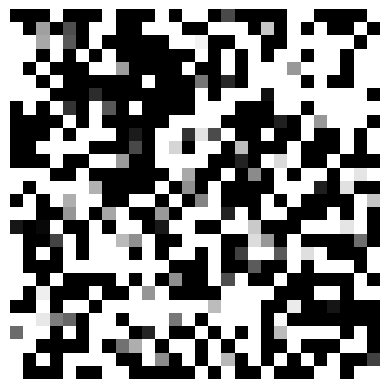

Step 114
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0178 - sparse_categorical_accuracy: 0.9998 - val_loss: 5.9605e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.737276 -9.545635]
 [ 9.737276 -9.545635]
 [ 9.737276 -9.545636]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 5s 7ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9976
Discriminator on random data after training generator:
tf.Tensor(
[[-22.500591   11.549668 ]
 [-22.500574   11.549655 ]
 [-22.500587   11.5496645]], shape=(3, 2), dtype=float32)


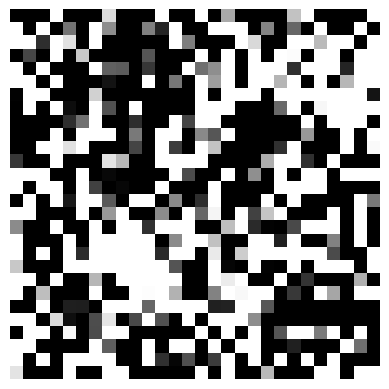

Step 115
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9993 - val_loss: 1.1921e-09 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.370697 -9.717881]
 [ 9.370696 -9.71788 ]
 [ 9.370699 -9.717883]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 0.0227 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-9.892338   7.5609636]
 [-9.892334   7.56096  ]
 [-9.892332   7.5609584]], shape=(3, 2), dtype=float32)


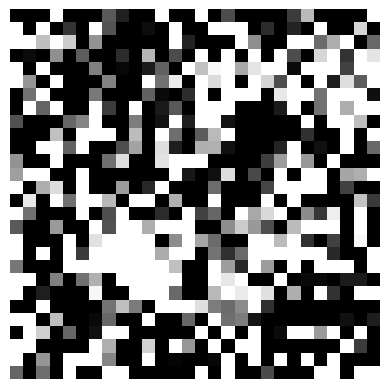

Step 116
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[  9.783414 -10.575644]
 [  9.783417 -10.575648]
 [  9.783416 -10.575645]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 5s 6ms/step - loss: 0.0242 - sparse_categorical_accuracy: 0.9988
Discriminator on random data after training generator:
tf.Tensor(
[[-49.560696  33.174313]
 [-49.56068   33.174305]
 [-49.560707  33.174316]], shape=(3, 2), dtype=float32)


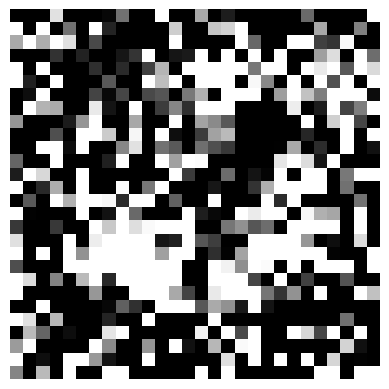

Step 117
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 10.572612 -11.19244 ]
 [ 10.572609 -11.192437]
 [ 10.572603 -11.192431]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 17.0112 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.163913  -8.6169615]
 [ 8.163914  -8.6169615]
 [ 8.163913  -8.6169615]], shape=(3, 2), dtype=float32)


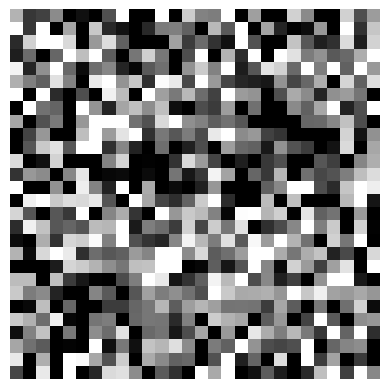

Step 118
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 9.9190e-08 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.496494 -8.98429 ]
 [ 8.496495 -8.984291]
 [ 8.496495 -8.98429 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 17.3790 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.419219 -8.899048]
 [ 8.419219 -8.899048]
 [ 8.419219 -8.899048]], shape=(3, 2), dtype=float32)


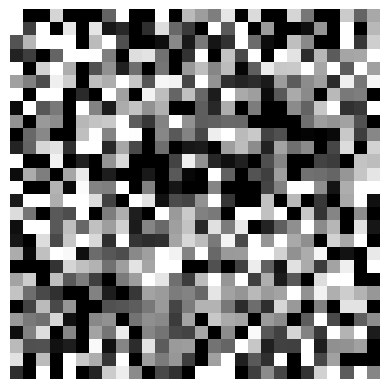

Step 119
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 7.1813e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.628606 -9.131207]
 [ 8.628606 -9.131207]
 [ 8.628606 -9.131207]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 17.7409 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.56158  -9.060583]
 [ 8.56158  -9.060583]
 [ 8.56158  -9.060583]], shape=(3, 2), dtype=float32)


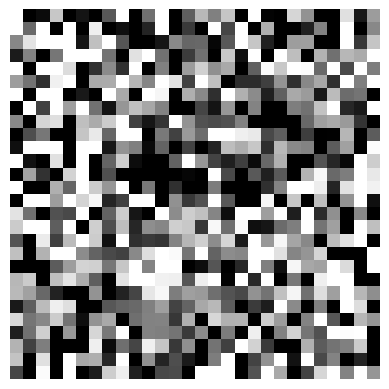

Step 120
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 7.1813e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.735936 -9.25397 ]
 [ 8.735936 -9.25397 ]
 [ 8.735936 -9.25397 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 17.9873 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.7055435 -9.220948 ]
 [ 8.7055435 -9.220948 ]
 [ 8.7055435 -9.220948 ]], shape=(3, 2), dtype=float32)


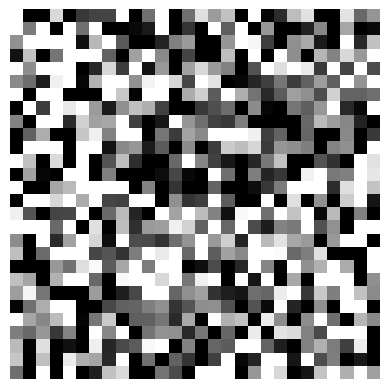

Step 121
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 3.7343e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.824    -9.352012]
 [ 8.824    -9.352012]
 [ 8.824    -9.352012]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.1745 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.800426 -9.323136]
 [ 8.800426 -9.323136]
 [ 8.800426 -9.323136]], shape=(3, 2), dtype=float32)


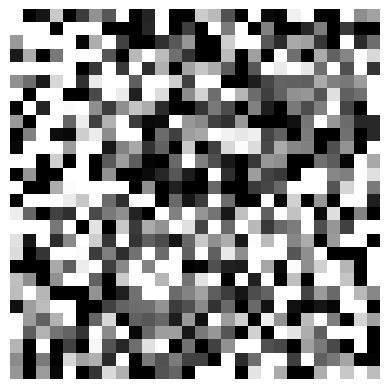

Step 122
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 4.3088e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.896569 -9.429665]
 [ 8.896569 -9.429665]
 [ 8.896569 -9.429665]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.3308 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.8983555 -9.432403 ]
 [ 8.8983555 -9.432403 ]
 [ 8.8983555 -9.432403 ]], shape=(3, 2), dtype=float32)


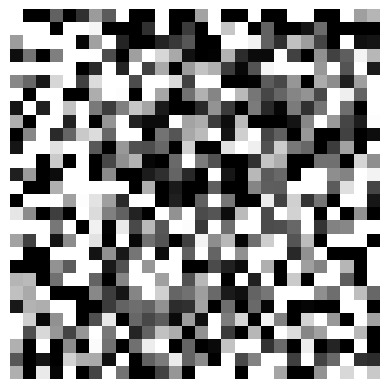

Step 123
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 4.3088e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.990832 -9.537296]
 [ 8.990832 -9.537296]
 [ 8.990832 -9.537296]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 5s 6ms/step - loss: 18.4370 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.934594 -9.476752]
 [ 8.934594 -9.476752]
 [ 8.934594 -9.476752]], shape=(3, 2), dtype=float32)


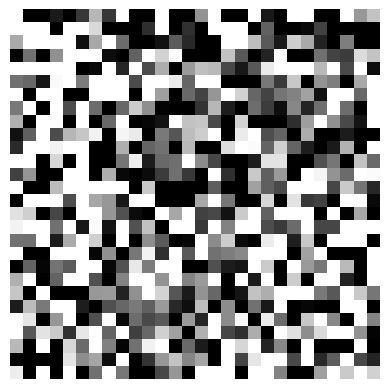

Step 124
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 1.4363e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.036465  -9.5916395]
 [ 9.036465  -9.5916395]
 [ 9.036465  -9.5916395]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.5609 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.989204 -9.5385  ]
 [ 8.989204 -9.5385  ]
 [ 8.989204 -9.5385  ]], shape=(3, 2), dtype=float32)


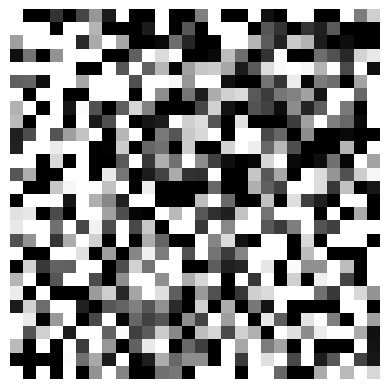

Step 125
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 2.8725e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.065761 -9.625322]
 [ 9.065761 -9.625322]
 [ 9.065761 -9.625322]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 5s 7ms/step - loss: 18.6617 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.012418 -9.566473]
 [ 9.012418 -9.566473]
 [ 9.012418 -9.566473]], shape=(3, 2), dtype=float32)


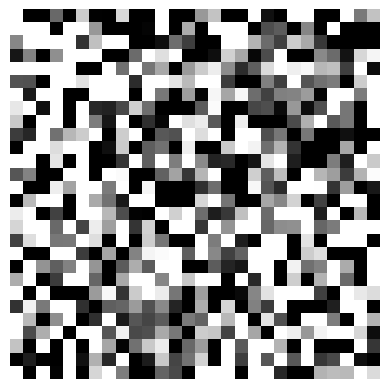

Step 126
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 2.8725e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.081629 -9.645049]
 [ 9.081629 -9.645049]
 [ 9.081629 -9.645049]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.7333 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.055774 -9.617908]
 [ 9.055774 -9.617908]
 [ 9.055774 -9.617908]], shape=(3, 2), dtype=float32)


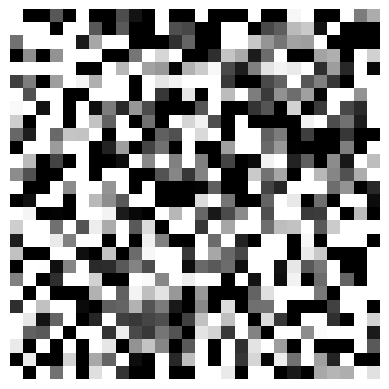

Step 127
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.106699 -9.675717]
 [ 9.106699 -9.675717]
 [ 9.106699 -9.675717]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.7272 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.04477  -9.607023]
 [ 9.04477  -9.607023]
 [ 9.04477  -9.607023]], shape=(3, 2), dtype=float32)


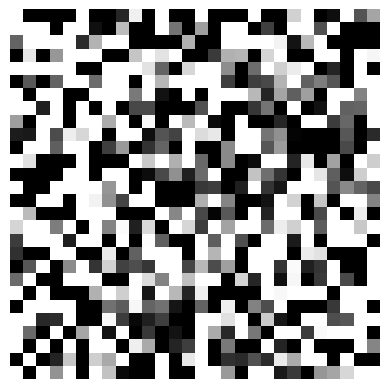

Step 128
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 7.1813e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.103451 -9.673655]
 [ 9.103451 -9.673655]
 [ 9.103451 -9.673655]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.7639 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.074139 -9.640038]
 [ 9.074139 -9.640038]
 [ 9.074139 -9.640038]], shape=(3, 2), dtype=float32)


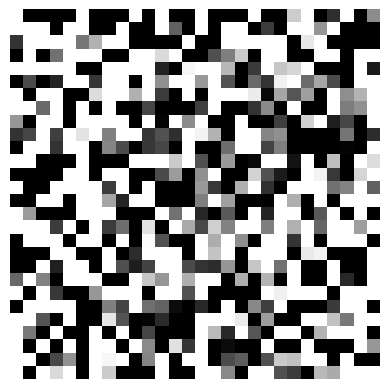

Step 129
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 2.8725e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.129218 -9.70258 ]
 [ 9.129218 -9.70258 ]
 [ 9.129218 -9.70258 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 5s 7ms/step - loss: 18.8280 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.107421 -9.679105]
 [ 9.107421 -9.679105]
 [ 9.107421 -9.679105]], shape=(3, 2), dtype=float32)


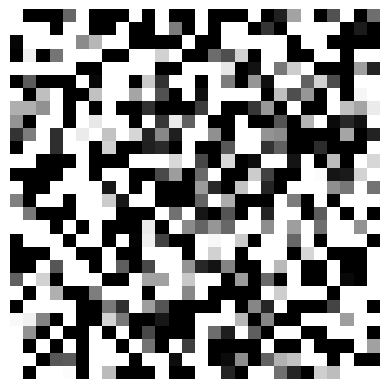

Step 130
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.174323 -9.755068]
 [ 9.174323 -9.755068]
 [ 9.174323 -9.755068]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.9097 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.134422 -9.708593]
 [ 9.134422 -9.708593]
 [ 9.134422 -9.708593]], shape=(3, 2), dtype=float32)


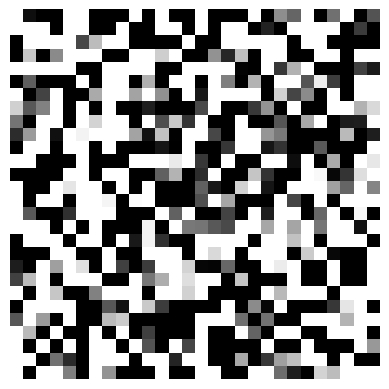

Step 131
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 4.3088e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.18082  -9.761507]
 [ 9.18082  -9.761507]
 [ 9.18082  -9.761507]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.9920 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.177123 -9.757529]
 [ 9.177123 -9.757529]
 [ 9.177123 -9.757529]], shape=(3, 2), dtype=float32)


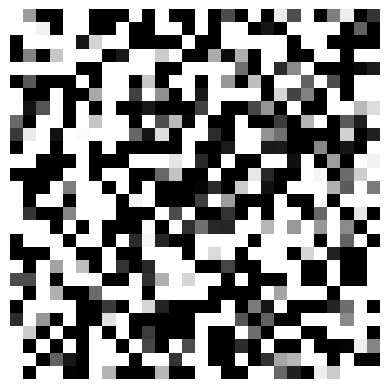

Step 132
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.23338  -9.821442]
 [ 9.23338  -9.821442]
 [ 9.23338  -9.821442]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 19.0581 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.237286 -9.830412]
 [ 9.237286 -9.830412]
 [ 9.237286 -9.830412]], shape=(3, 2), dtype=float32)


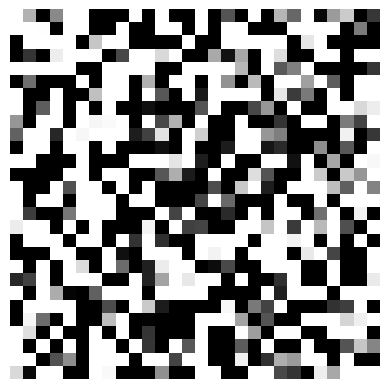

Step 133
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 1.3070e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.30029  -9.902545]
 [ 9.30029  -9.902545]
 [ 9.30029  -9.902545]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 19.1140 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.242838 -9.840908]
 [ 9.242838 -9.840908]
 [ 9.242838 -9.840908]], shape=(3, 2), dtype=float32)


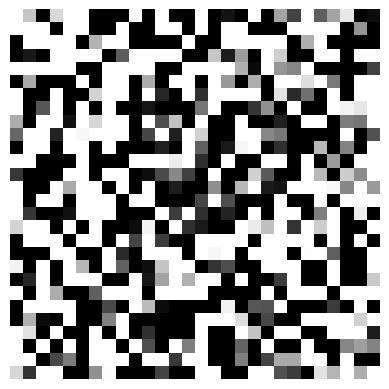

Step 134
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 5.7450e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.296099 -9.902231]
 [ 9.296099 -9.902231]
 [ 9.296099 -9.902231]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 19.1716 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.271159 -9.869865]
 [ 9.271159 -9.869865]
 [ 9.271159 -9.869865]], shape=(3, 2), dtype=float32)


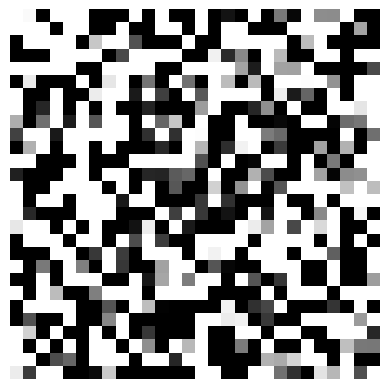

Step 135
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 2.8725e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.316729 -9.921947]
 [ 9.316729 -9.921947]
 [ 9.316729 -9.921947]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 19.2277 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.291853 -9.890041]
 [ 9.291853 -9.890041]
 [ 9.291853 -9.890041]], shape=(3, 2), dtype=float32)


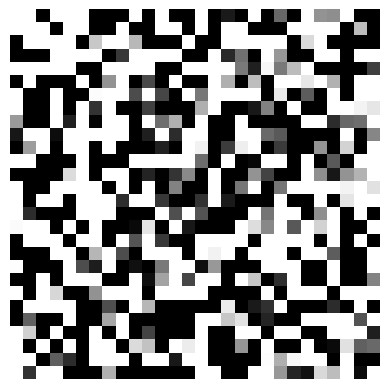

Step 136
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.330285 -9.93523 ]
 [ 9.330285 -9.93523 ]
 [ 9.330285 -9.93523 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 19.2876 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.329024 -9.935441]
 [ 9.329024 -9.935441]
 [ 9.329024 -9.935441]], shape=(3, 2), dtype=float32)


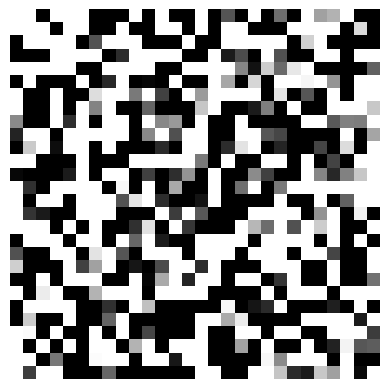

Step 137
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.359611 -9.971409]
 [ 9.359611 -9.971409]
 [ 9.359611 -9.971409]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.7869 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.846602 -9.386047]
 [ 8.846602 -9.386047]
 [ 8.846602 -9.386047]], shape=(3, 2), dtype=float32)


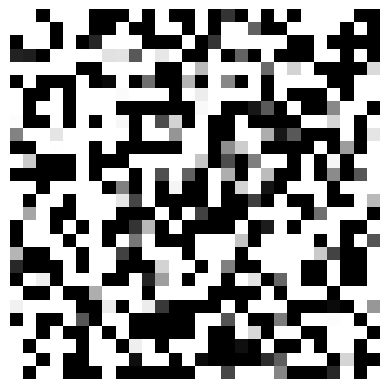

Step 138
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.917187 -9.466884]
 [ 8.917187 -9.466884]
 [ 8.917187 -9.466884]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.0968 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.655116 -9.162603]
 [ 8.655116 -9.162603]
 [ 8.655116 -9.162603]], shape=(3, 2), dtype=float32)


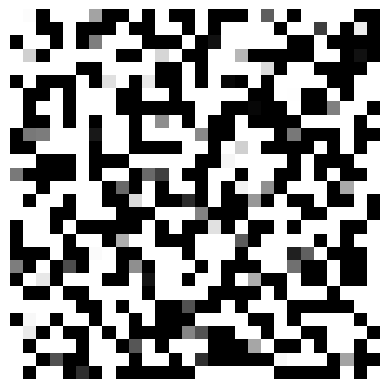

Step 139
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 8.900437 -9.43865 ]
 [ 8.900437 -9.43865 ]
 [ 8.900437 -9.43865 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.0988 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.783737  -9.3062525]
 [ 8.783737  -9.3062525]
 [ 8.783737  -9.3062525]], shape=(3, 2), dtype=float32)


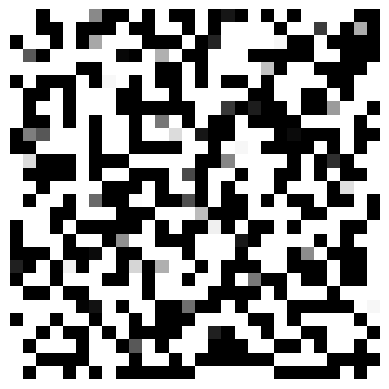

Step 140
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 1.4363e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.041862 -9.594137]
 [ 9.041862 -9.594137]
 [ 9.041862 -9.594137]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.2652 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.844294  -9.3713045]
 [ 8.844294  -9.3713045]
 [ 8.844294  -9.3713045]], shape=(3, 2), dtype=float32)


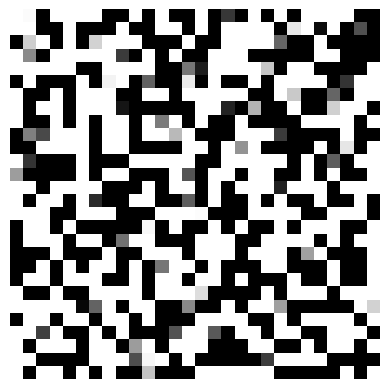

Step 141
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 2.8725e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.032182 -9.58126 ]
 [ 9.032182 -9.58126 ]
 [ 9.032182 -9.58126 ]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.4324 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.934899 -9.475058]
 [ 8.934899 -9.475058]
 [ 8.934899 -9.475058]], shape=(3, 2), dtype=float32)


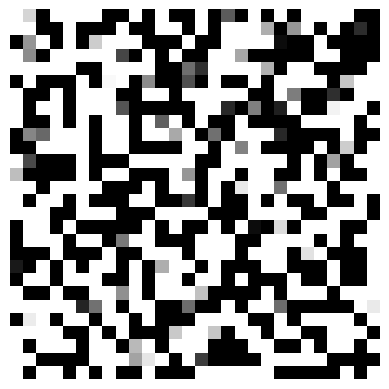

Step 142
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.019618 -9.571042]
 [ 9.019618 -9.571042]
 [ 9.019618 -9.571042]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.4920 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 8.99121  -9.553297]
 [ 8.99121  -9.553297]
 [ 8.99121  -9.553297]], shape=(3, 2), dtype=float32)


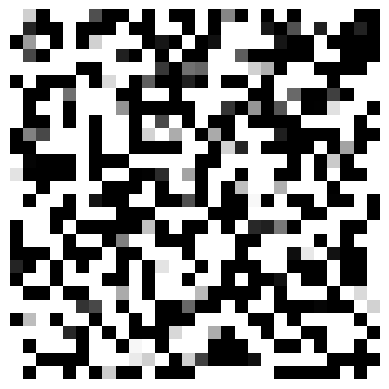

Step 143
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 2.8725e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.081704 -9.655923]
 [ 9.081704 -9.655923]
 [ 9.081704 -9.655923]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.5874 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.003582 -9.583938]
 [ 9.003582 -9.583938]
 [ 9.003582 -9.583938]], shape=(3, 2), dtype=float32)


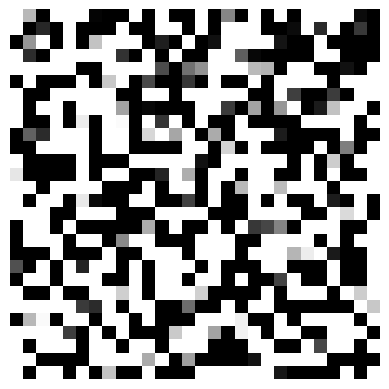

Step 144
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.09662  -9.690223]
 [ 9.09662  -9.690223]
 [ 9.09662  -9.690223]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.6937 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.0441265 -9.622746 ]
 [ 9.0441265 -9.622746 ]
 [ 9.0441265 -9.622746 ]], shape=(3, 2), dtype=float32)


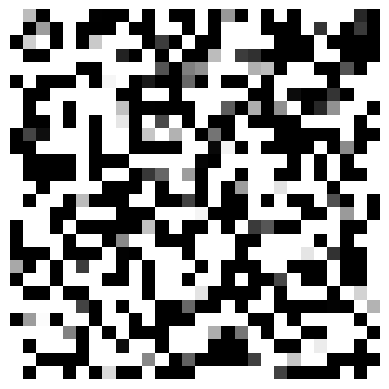

Step 145
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.0917225 -9.6782465]
 [ 9.0917225 -9.6782465]
 [ 9.0917225 -9.6782465]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.7838 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.108311 -9.70765 ]
 [ 9.108311 -9.70765 ]
 [ 9.108311 -9.70765 ]], shape=(3, 2), dtype=float32)


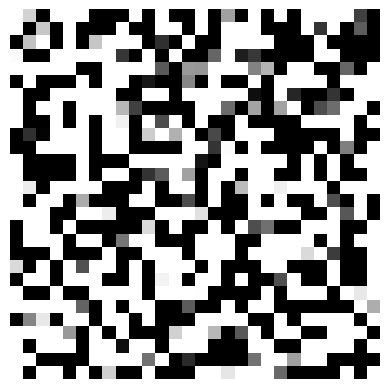

Step 146
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 1.4363e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.219517 -9.835165]
 [ 9.219517 -9.835165]
 [ 9.219517 -9.835165]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.8806 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.1335745 -9.727829 ]
 [ 9.1335745 -9.727829 ]
 [ 9.1335745 -9.727829 ]], shape=(3, 2), dtype=float32)


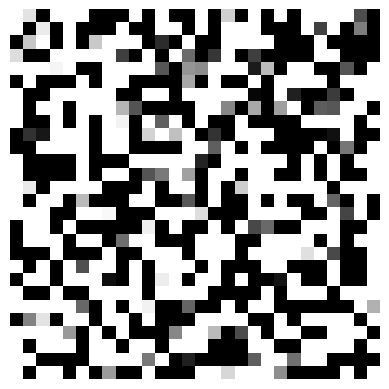

Step 147
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 2.8725e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.188316 -9.790422]
 [ 9.188316 -9.790422]
 [ 9.188316 -9.790422]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 18.9752 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.273249 -9.872719]
 [ 9.273249 -9.872719]
 [ 9.273249 -9.872719]], shape=(3, 2), dtype=float32)


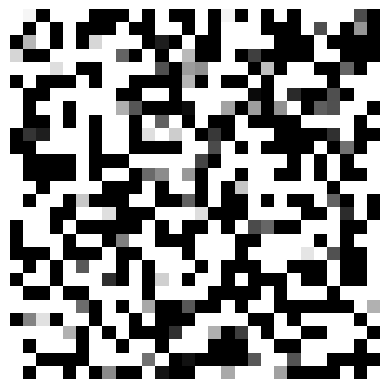

Step 148
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 1.4363e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Discriminator on random data after training discriminator:
tf.Tensor(
[[ 9.328109 -9.934808]
 [ 9.328109 -9.934808]
 [ 9.328109 -9.934808]], shape=(3, 2), dtype=float32)
Training generator
840/840 [==============================] - 6s 7ms/step - loss: 19.0401 - sparse_categorical_accuracy: 0.0000e+00
Discriminator on random data after training generator:
tf.Tensor(
[[ 9.201633 -9.808014]
 [ 9.201633 -9.808014]
 [ 9.201633 -9.808014]], shape=(3, 2), dtype=float32)


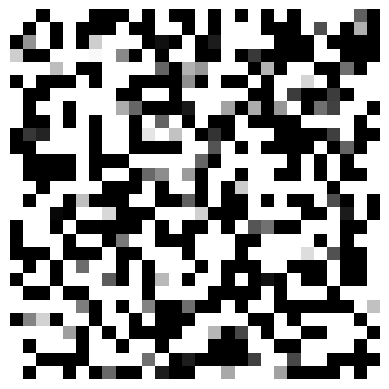

Step 149
Training discriminator
8400
8400
1660/1660 [==============================] - 7s 4ms/step - loss: 1.4363e-11 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000


KeyboardInterrupt: 

In [18]:
for i in range(200):
    print("Step", i)
    print("Training discriminator")
    discriminator.trainable = True
    train_discriminator()
    x =  np.random.random_sample((3, 10)) - 0.5
    print("Discriminator on random data after training discriminator:")
    print(gandd(x))
    
    print("Training generator")
    train_generator()
    x =  np.random.random_sample((3, 10)) - 0.5
    print("Discriminator on random data after training generator:")
    print(gandd(x))
    output = gen_model(x)
    plt.imshow(output[0].numpy().reshape(28, 28),cmap='gray', vmin=-1.0, vmax=1.0)
    plt.axis("off")
    plt.show()
    

In [ ]:
gen_model.save('/kaggle/working/gen_model')
discriminator.save('kaggle/working/discriminator')